In [3]:
!pip install seaborn pandas matplotlib skunk svglib

In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
print(symd.__version__)

0.2.1


## Atlas

In [3]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)

def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim,ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:,:ndim], ib)    
    members = [symd.groups.str2mat(e) for e in group['genpos']]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i,:] = s[i,:]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]            
            folded_positions[i,:] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]            
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]    
    return np.mean((s[:k] - folded_positions[:k])**2)
def rmsd(p1, p2):
    return np.mean((p1 - p2)**2, axis=(1,2))

In [24]:
def crystal(n, group, w=None, retries=5, steps=10**6, steps2=5*10**3, ndims=2, starting_density=0.2, positions=False):
    # adjust for group size
    m = len(symd.groups.load_group(group, ndims)['genpos'])
    n = max(2, n // m)
    if w is not None:
        n += sum(w)
        name = f'{group}-{n}-{sum(w)}'
    else:
        name = f'{group}-{n}'
    print('Simulating', n, 'particles:', name)
    # break out the try/except because we will accept failed NPT (because it jams so hard)
    for i in range(retries):
        np.random.seed(i)
        cell = symd.groups.get_cell(starting_density, group, 2, n, w)
        # NPT
        md = symd.Symd(nparticles=n, cell=cell, ndims=ndims, images=2, force='lj', wyckoffs=w,
          group=group, steps=steps, exeDir=f'crystal-{name}', pressure=0.25, temperature=0.1, start_temperature=0.5)
        try:        
            md.remove_overlap()
        except RuntimeError as e:
            continue
        if positions:
            md.log_positions(period=250)            
        else:
            md.log_positions()
        try:
            md.run()
        except RuntimeError as e:
            d = md.number_density()
            if d < 0.5:
                print('Not dense enough, retrying', d)
                continue

        # NVT
        md.runParams['start_temperature'] = 0.05
        md.runParams['temperature'] = 1e-4
        md.runParams['box_update_period'] = 0
        md.runParams['langevin_gamma'] = 0.5
        md.runParams['steps'] = steps // 4
        md.log_positions(filename='equil.xyz')
        try:
            md.run()
        except RuntimeError as e:
            continue
        config = md.positions[-1]

        # Stability
        fp = np.loadtxt(md.runParams['final_positions'])
        # changing group, so need to read projected cell
        cell = md.read_cell(bravais=True)
        m = fp.shape[0]
        md2 = symd.Symd(nparticles=m, cell=cell, ndims=2, images=2, force='lj', wyckoffs=None,
          group=1, steps=steps2, exeDir=f'melt-{name}', temperature=None, start_temperature=0.0)
        # run once to get melting traj
        # then again for longer with longer period
        md2.log_positions(period=10)
        md2.runParams['start_positions'] = md.runParams['final_positions']            
        try:
            md2.run()
        except RuntimeError as e:
            continue
        traj = md2.positions
        csm = rmsd(md2.positions[:,:m], md2.positions[0,:m])
        #csm = []
        #for i in range(md2.positions.shape[0]):
        #    csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
        if positions:
            return np.concatenate((md.positions, md2.positions))
        return config, md2.positions[-1], md2.number_density(), csm, traj, np.arange(0,steps2,10) * md2.runParams['time_step']
    return None

In [5]:
config, config2, nd, csm, traj, time = crystal(10, 6)

Simulating 2 particles: 6-2
{"steps": 1000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-2/group-6.dat", "cell_log_file": "crystal-6-2/cell_log_file.dat", "print_period": 10000.0, "cell": [6.32465, 0.0, 0.0, 6.32465], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-2/group-6.dat", "group": "crystal-6-2/group-6.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 2 particles and 4 members
Info: Duplicating 2 particles into 2 real particles and 198 ghost for group with 4 elements and 24 tilings. Each cell has 8 particles.
Info: Computed 4 degrees of freedom
        Step        

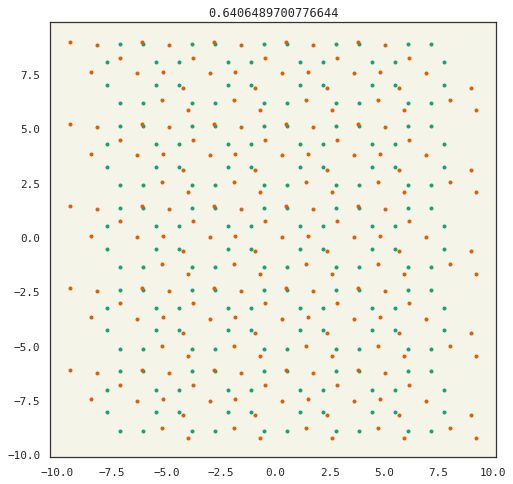

In [6]:
plt.figure(figsize=(8, 8))
plt.title(f'{nd}')
plt.plot(config[:,0], config[:,1], '.')
plt.plot(config2[:,0], config2[:,1], '.')

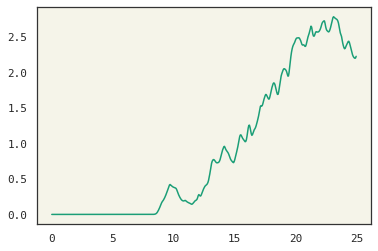

In [7]:
plt.plot(time, csm)

In [123]:
are you sure you want to run this?
from multiprocessing import Pool

cdf = None
results = []
trajs = {}

with Pool() as pool:
    for N in [8,16,32,128]:
        for i,t in enumerate(titles):
            W = len(symd.groups.load_group(i+1, 2)['specpos'])    
            for j in range(1 + W):
                wycks = None if j == 0 else [1] * j
                name = f'{t}-w{j}-n{N}'
                job = pool.apply_async(crystal, (N, i+1, wycks))
                #job = crystal(N, i+1, wycks)
                results.append((t, name, N, j, job))
                
    for r in results:        
        t, name, N, j, ar = r
        print('Getting result for ', name)
        res = ar.get()
        #res = ar
        if res is None:
            continue
        config, config2, nd, csm, traj, time = res
        T = len(csm)
        
        df2 = pd.DataFrame({'Group':[t] * T, 'Traj': [name] * T, 'rho': [nd] * T,
                            'N':[N] * T, 'Wyckoffs':[str(j)] * T, 'RMSD':csm, 'Time':time})
        if cdf is None:
            cdf = df2
        else:
            cdf = pd.concat((cdf, df2))
        trajs[name] = traj
        
cdf.reset_index(inplace=True)
cdf.to_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

SimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulating  Simulating SimulatingSimulatingSimulating  Simulating Simulating Simulating     8465 48 6  73245    3 5  42     particles:particles:particles:particles:particles: particles: particles: particles: particles:particles:particles:particles:    particles: particles:  particles:particles:     1-82-42-6-22-5-1 2-8-4 3-4  3-6-22-7-35-3-15-24-43-5-1



6-3-1
6-5-3

6-4-26-2








Getting result for  p1-w0-n8
{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-5-1/group-3.dat", "cell_log_file": "crystal-3-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.70821, 0.0, 0.0, 6.70821], "lj_epsilon

Simulating 7 particles: 9-7-5
Simulating 2{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-6-4/group-9.dat", "cell_log_file": "crystal-9-6-4/cell_log_file.dat", "print_period": 10000.0, "cell": [12.2474, 0.0, 0.0, 12.2474], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-9-6-4/group-9.dat", "group": "crystal-9-6-4/group-9.json", "wyckoffs": [{"group": "crystal-9-6-4/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-01.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-02.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-03.json", "n_particles": 1}]} 
particles:Info: You are running version cf97-dirty of symd
Assuming


Exiting due to high temperature or energy  (T = 4.21535e+30)

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4-2/group-12.dat", "cell_log_file": "crystal-12-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.24406, 0.0, 0.0, 5.24406], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-4-2/group-12.dat", "group": "crystal-12-4-2/group-12.json", "wyckoffs": [{"group": "crystal-12-4-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-4-2/group-12-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 member


Exiting due to high temperature or energy  (T = 1.09538e+26)

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-3/group-12.dat", "cell_log_file": "crystal-12-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.47719, 0.0, 0.0, 5.47719], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-3/group-12.dat", "group": "crystal-12-5-3/group-12.json", "wyckoffs": [{"group": "crystal-12-5-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wait

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4-2/group-12.dat", "cell_log_file": "crystal-12-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.24406, 0.0, 0.0, 5.24406], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-4-2/group-12.dat", "group": "crystal-12-4-2/group-12.json", "wyckoffs": [{"group": "crystal-12-4-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-4-2/group-12-01.json", "n_particles": 1}]} 
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-3/group-12.dat", "cell_log_file": "crystal-12-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.47719, 0.0, 0.0, 5.47719], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-3/group-12.dat", "group": "crystal-12-5-3/group-12.json", "wyckoffs": [{"group": "crystal-12-5-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-02.json", "n_particles": 1}]}
Simulating Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles 


Exiting due to high temperature or energy  (T = 4.48428e+26)

Simulating 3 particles: 16-3-1
Simulating Getting result for  p4-w0-n8
Getting result for  p4-w1-n8
Getting result for  p4-w2-n8
Getting result for  p4-w3-n8
Getting result for  p4m-w0-n8
Getting result for  p4m-w1-n8
4 particles: 16-4-2
Simulating 5 particles: 16-5-3
Simulating 17-2Getting result for  p4m-w2-n8
Getting result for  p4m-w3-n8
2 particles: 
SimulatingSimulating 4 particles: 17-4-2
 3 particles: 17-3-1
{"steps": 5000, "n_particles": 30, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-6-4/final_positions.dat", "cell_log_file": "melt-11-6-4/cell_log_file.dat", "print_period": 50.0, "cell": [4.82652, 0.0, 0.0, 4.82652], "lj_epsilon": 1, "lj_sigma":


Exiting due to high temperature or energy  (T = 6.20539e+25)

Simulating 8 particles: 4-8
Simulating 4 particles: 5-4
{"steps": 5000, "n_particles": 30, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-6-4/final_positions.dat", "cell_log_file": "melt-11-6-4/cell_log_file.dat", "print_period": 50.0, "cell": [4.71673, 0.0, 0.0, 4.71673], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-6-4/final_positions.dat", "group": "melt-11-6-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-6-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 30 particles and 1 members
Info: Duplicat


Exiting due to high temperature or energy  (T = 1.62722e+25)

Simulating 5Simulating 4 particles: 6-4
 particles: 5-5-1
Simulating 5 particles: 6-5-1
{"steps": 5000, "n_particles": 28, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-5-3/final_positions.dat", "cell_log_file": "melt-11-5-3/cell_log_file.dat", "print_period": 50.0, "cell": [4.6502, 0.0, 0.0, 4.6502], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-5-3/final_positions.dat", "group": "melt-11-5-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-5-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 28 particle

{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-6-4/group-9.dat", "cell_log_file": "crystal-9-6-4/cell_log_file.dat", "print_period": 10000.0, "cell": [12.2474, 0.0, 0.0, 12.2474], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-9-6-4/group-9.dat", "group": "crystal-9-6-4/group-9.json", "wyckoffs": [{"group": "crystal-9-6-4/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-01.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-02.json", "n_particles": 1}, {"group": "crystal-9-6-4/group-9-03.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: L


Exiting due to high temperature or energy  (T = 2.07299e+25)

{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-3-1/group-12.dat", "cell_log_file": "crystal-12-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [5.00003, 0.0, 0.0, 5.00003], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-3-1/group-12.dat", "group": "crystal-12-3-1/group-12.json", "wyckoffs": [{"group": "crystal-12-3-1/group-12-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members
I

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-3/group-12.dat", "cell_log_file": "crystal-12-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.47719, 0.0, 0.0, 5.47719], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-3/group-12.dat", "group": "crystal-12-5-3/group-12.json", "wyckoffs": [{"group": "crystal-12-5-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-02.json", "n_particles": 1}]}

Exiting due to high temperature or energy  (T = 8.35286e+35)
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiti


Exiting due to high temperature or energy  (T = 6.05639e+27)

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-3/group-12.dat", "cell_log_file": "crystal-12-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.47719, 0.0, 0.0, 5.47719], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-3/group-12.dat", "group": "crystal-12-5-3/group-12.json", "wyckoffs": [{"group": "crystal-12-5-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-5-3/group-12-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wait


Exiting due to high temperature or energy  (T = 4.48428e+26)

Simulating 4 particles: 15-4-2
Getting result for  p4-w0-n16
Getting result for  p4-w1-n16
Getting result for  p4-w2-n16
Getting result for  p4-w3-n16
Getting result for  p4m-w0-n16
Getting result for  p4m-w1-n16
{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-4-2/group-15.dat", "cell_log_file": "crystal-15-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.95352, 0.0, 0.0, 4.95352], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-4-2/group-15.dat", "group": "crystal-15-4-2/group-15.json", "wyckoffs": [{"group": "crystal-15-4-2/group-15-00.json", "n_particles": 1}, {"group": "c


Exiting due to high temperature or energy  (T = 2.03833e+26)

Simulating 19 particles: 2-19-3
{"steps": 1000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-2-18-2/group-2.dat", "cell_log_file": "crystal-2-18-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.0383, 0.0, 0.0, 13.0383], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-2-18-2/group-2.dat", "group": "crystal-2-18-2/group-2.json", "wyckoffs": [{"group": "crystal-2-18-2/group-2-00.json", "n_particles": 1}, {"group": "crystal-2-18-2/group-2-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-2 wi


Exiting due to high temperature or energy  (T = 2.51563e+25)

{"steps": 1000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-16/group-3.dat", "cell_log_file": "crystal-3-16/cell_log_file.dat", "print_period": 10000.0, "cell": [12.6491, 0.0, 0.0, 12.6491], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-3-16/group-3.dat", "group": "crystal-3-16/group-3.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-3 with 16 particles and 2 members
Info: Duplicating 16 particles into 16 real particles and 784 ghost for group with 2 elements and 24 tilings. Each cell has 32 particles.
Info: Comput


Exiting due to high temperature or energy  (T = 6.20539e+25)

{"steps": 1000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-18-2/group-3.dat", "cell_log_file": "crystal-3-18-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.0383, 0.0, 0.0, 13.0383], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-3-18-2/group-3.dat", "group": "crystal-3-18-2/group-3.json", "wyckoffs": [{"group": "crystal-3-18-2/group-3-00.json", "n_particles": 1}, {"group": "crystal-3-18-2/group-3-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-3 with 16 particles and 2 members
In


Exiting due to high temperature or energy  (T = 1.62722e+25)

{"steps": 5000, "n_particles": 39, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-5-3/final_positions.dat", "cell_log_file": "melt-17-5-3/cell_log_file.dat", "print_period": 50.0, "cell": [6.25566, -3.12783, 0.0, 5.41756], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-5-3/final_positions.dat", "group": "melt-17-5-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-5-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 39 particles and 1 members
Info: Duplicating 39 particles into 39 real particles and 936 gho


Exiting due to high temperature or energy  (T = 9.78198e+46)

Simulating 12 particles: 6-12-4
Simulating 13 particles: 6-13-5
{"steps": 1000, "n_particles": 13, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-13-5/group-6.dat", "cell_log_file": "crystal-6-13-5/cell_log_file.dat", "print_period": 10000.0, "cell": [14.3179, 0.0, 0.0, 14.3179], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-13-5/group-6.dat", "group": "crystal-6-13-5/group-6.json", "wyckoffs": [{"group": "crystal-6-13-5/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-13-5/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-13-5/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-13-5/group-6-03.j


Exiting due to high temperature or energy  (T = 2.4081e+25)

Simulating 9 particles: 7-9-1
Simulating 10 particles: 7-10-2
Simulating 11 particles: 7-11-3
{"steps": 1000, "n_particles": 11, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-7-11-3/group-7.dat", "cell_log_file": "crystal-7-11-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.7842, 0.0, 0.0, 13.7842], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-7-11-3/group-7.dat", "group": "crystal-7-11-3/group-7.json", "wyckoffs": [{"group": "crystal-7-11-3/group-7-00.json", "n_particles": 1}, {"group": "crystal-7-11-3/group-7-01.json", "n_particles": 1}, {"group": "crystal-7-11-3/group-7-02.json", "n_particles": 1}]}
Info: Yo


Exiting due to high temperature or energy  (T = 1.80318e+25)

Simulating 8 particles: 9-8-4
{"steps": 5000, "n_particles": 40, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-6-12-4/final_positions.dat", "cell_log_file": "melt-6-12-4/cell_log_file.dat", "print_period": 50.0, "cell": [5.12848, 0.0, 0.0, 5.35121], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-6-12-4/final_positions.dat", "group": "melt-6-12-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-6-12-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 40 particles and 1 members
Info: Duplicating 40 particles into 40 r


Exiting due to high temperature or energy  (T = 9.73995e+29)

Simulating 7 particles: 11-7-3
Simulating 8 particles: 11-8-4
Simulating 9 particles: 11-9-5
{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-7-8/final_positions.dat", "cell_log_file": "melt-7-8/cell_log_file.dat", "print_period": 50.0, "cell": [5.282, 0.0, 0.0, 4.10286], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-7-8/final_positions.dat", "group": "melt-7-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-7-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 me


Exiting due to high temperature or energy  (T = 1.47179e+26)

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-4/final_positions.dat", "cell_log_file": "melt-11-4/cell_log_file.dat", "print_period": 50.0, "cell": [5.1102, 0.0, 0.0, 5.1102], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-4/final_positions.dat", "group": "melt-11-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with


Exiting due to high temperature or energy  (T = 2.95724e+26)

Simulating 10 particles: 11-10-6
{"steps": 5000, "n_particles": 40, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-6-2/final_positions.dat", "cell_log_file": "melt-11-6-2/cell_log_file.dat", "print_period": 50.0, "cell": [5.69451, 0.0, 0.0, 5.69451], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-6-2/final_positions.dat", "group": "melt-11-6-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-6-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 40 particles and 1 members
Info: Duplicating 40 particles into 4


Exiting due to high temperature or energy  (T = 1.12083e+26)

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-1/group-12.dat", "cell_log_file": "crystal-12-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.70821, 0.0, 0.0, 6.70821], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-1/group-12.dat", "group": "crystal-12-5-1/group-12.json", "wyckoffs": [{"group": "crystal-12-5-1/group-12-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members
I


Exiting due to high temperature or energy  (T = 2.71223e+31)

{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-6-2/group-12.dat", "cell_log_file": "crystal-12-6-2/cell_log_file.dat", "print_period": 10000.0, "cell": [6.89203, 0.0, 0.0, 6.89203], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-6-2/group-12.dat", "group": "crystal-12-6-2/group-12.json", "wyckoffs": [{"group": "crystal-12-6-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-6-2/group-12-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 member


Exiting due to high temperature or energy  (T = 3.98116e+27)

{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-6-2/group-12.dat", "cell_log_file": "crystal-12-6-2/cell_log_file.dat", "print_period": 10000.0, "cell": [6.89203, 0.0, 0.0, 6.89203], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-6-2/group-12.dat", "group": "crystal-12-6-2/group-12.json", "wyckoffs": [{"group": "crystal-12-6-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-6-2/group-12-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 member


Exiting due to high temperature or energy  (T = 1.42907e+30)

 12 particles: 13-12-2
Simulating 13 particles: {"steps": 5000, "n_particles": 40, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-6-12-4/final_positions.dat", "cell_log_file": "melt-6-12-4/cell_log_file.dat", "print_period": 50.0, "cell": [5.66419, 0.0, 0.0, 4.76018], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-6-12-4/final_positions.dat", "group": "melt-6-12-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-6-12-4/positions.xyz"}13-13-3

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 40 particles and 1 members
Info: Duplicat

Simulating 5 particles: 
14-5
Exiting due to high temperature or energy  (T = 1.84365e+30)

{"steps": 1000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-12-4/group-6.dat", "cell_log_file": "crystal-6-12-4/cell_log_file.dat", "print_period": 10000.0, "cell": [14.1421, 0.0, 0.0, 14.1421], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-12-4/group-6.dat", "group": "crystal-6-12-4/group-6.json", "wyckoffs": [{"group": "crystal-6-12-4/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-12-4/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-12-4/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-12-4/group-6-03.json", "n_particles": 1}]}
Info: You


Exiting due to high temperature or energy  (T = 1.06786e+53)


Simulating 6 particles:Getting result for  pmm-w5-n32
Getting result for  pmm-w6-n32
Getting result for  pmm-w7-n32
Getting result for  pmm-w8-n32
 14-6-1
{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-6-1/group-14.dat", "cell_log_file": "crystal-14-6-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.90155, 0.0, 0.0, 6.90155], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-6-1/group-14.dat", "group": "crystal-14-6-1/group-14.json", "wyckoffs": [{"group": "crystal-14-6-1/group-14-00.json", "n_particles": 1}]}
Simulating 7 particles: 14-7-2
Info: You are running version cf97-di

14-9-4

Exiting due to high temperature or energy  (T = 1.18816e+30)

Simulating{"steps": 5000, "n_particles": 36, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-5-1/final_positions.dat", "cell_log_file": "melt-11-5-1/cell_log_file.dat", "print_period": 50.0, "cell": [5.18772, 0.0, 0.0, 5.18772], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-5-1/final_positions.dat", "group": "melt-11-5-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-5-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 36 particles and 1 members
Info: Duplicating 36 particles into 36 real particles


Exiting due to high temperature or energy  (T = 2.89453e+30)

{"steps": 1000000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-5/final_positions.dat", "cell_log_file": "crystal-14-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.73018, 0.0, 0.0, 2.55705], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-5/final_positions.dat", "group": "crystal-14-5/group-14.json", "position_log_period": 10000, "positions_log_file": "crystal-14-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 5 particles and 6 members
Info: Duplicating 5 particles into 5 real particles


Exiting due to high temperature or energy  (T = 7.95118e+29)

Simulating 6 particles: 15-6-1
{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-4/final_positions.dat", "cell_log_file": "melt-11-4/cell_log_file.dat", "print_period": 50.0, "cell": [4.85792, 0.0, 0.0, 4.85792], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-4/final_positions.dat", "group": "melt-11-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real parti


Exiting due to high temperature or energy  (T = 5.67499e+28)

{"steps": 5000, "n_particles": 40, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-6-2/final_positions.dat", "cell_log_file": "melt-11-6-2/cell_log_file.dat", "print_period": 50.0, "cell": [5.27481, 0.0, 0.0, 5.27481], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-6-2/final_positions.dat", "group": "melt-11-6-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-6-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 40 particles and 1 members
Info: Duplicating 40 particles into 40 real particles and 960 ghost fo

Simulating 6 particles: 17-6-4
Simulating 7 Simulatingparticles: 17-7-5 
128 particles: 1-128
{"steps": 1000000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-5-1/final_positions.dat", "cell_log_file": "crystal-11-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [2.83975, 0.0, 0.0, 2.35062], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-5-1/final_positions.dat", "group": "crystal-11-5-1/group-11.json", "wyckoffs": [{"group": "crystal-11-5-1/group-11-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-11-5-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wa


Exiting due to high temperature or energy  (T = 6.57577e+32)

Simulating 64 particles: 2-64
Simulating 65 particles: 2-65-1
{"steps": 1000000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-16-5/final_positions.dat", "cell_log_file": "crystal-16-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.22179, 0.0, 0.0, 2.20019], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-16-5/final_positions.dat", "group": "crystal-16-5/group-16.json", "position_log_period": 10000, "positions_log_file": "crystal-16-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-16 with 5 particles and

{"steps": 5000, "n_particles": 36, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-5-1/final_positions.dat", "cell_log_file": "melt-11-5-1/cell_log_file.dat", "print_period": 50.0, "cell": [5.19037, 0.0, 0.0, 5.19037], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-5-1/final_positions.dat", "group": "melt-11-5-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-5-1/positions.xyz"}

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 36 particles and 1 members
Info: Duplicating 36 particles into 36 real particles and 864 ghost for group with 1 elements and 24 tilings. Each cell has 36 parti


Exiting due to high temperature or energy  (T = 2.05284e+46)

{"steps": 1000, "n_particles": 66, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-66-2/group-3.dat", "cell_log_file": "crystal-3-66-2/cell_log_file.dat", "print_period": 10000.0, "cell": [25.4951, 0.0, 0.0, 25.4951], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-3-66-2/group-3.dat", "group": "crystal-3-66-2/group-3.json", "wyckoffs": [{"group": "crystal-3-66-2/group-3-00.json", "n_particles": 1}, {"group": "crystal-3-66-2/group-3-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-3 with 64 particles and 2 members
In


Exiting due to high temperature or energy  (T = 1.60473e+26)

{"steps": 1000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-5-32/group-5.dat", "cell_log_file": "crystal-5-32/cell_log_file.dat", "print_period": 10000.0, "cell": [25.2982, 0.0, 0.0, 25.2982], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-5-32/group-5.dat", "group": "crystal-5-32/group-5.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-5 with 32 particles and 4 members
Info: Duplicating 32 particles into 32 real particles and 3168 ghost for group with 4 elements and 24 tilings. Each cell has 128 particles.
Info: Comp


{"steps": 1000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-32/group-6.dat", "cell_log_file": "crystal-6-32/cell_log_file.dat", "print_period": 10000.0, "cell": [25.2982, 0.0, 0.0, 25.2982], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-32/group-6.dat", "group": "crystal-6-32/group-6.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 32 particles and 4 members
Info: Duplicating 32 particles into 32 real particles and 3168 ghost for group with 4 elements and 24 tilings. Each cell has 128 particles.
Info: Computed 64 degrees of freedom
        Step         Time          

{"steps": 1000, "n_particles": 36, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-36-4/group-6.dat", "cell_log_file": "crystal-6-36-4/cell_log_file.dat", "print_period": 10000.0, "cell": [26.0768, 0.0, 0.0, 26.0768], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-36-4/group-6.dat", "group": "crystal-6-36-4/group-6.json", "wyckoffs": [{"group": "crystal-6-36-4/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-36-4/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-36-4/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-36-4/group-6-03.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting..

{"steps": 1000, "n_particles": 40, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-40-8/group-6.dat", "cell_log_file": "crystal-6-40-8/cell_log_file.dat", "print_period": 10000.0, "cell": [26.4575, 0.0, 0.0, 26.4575], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-40-8/group-6.dat", "group": "crystal-6-40-8/group-6.json", "wyckoffs": [{"group": "crystal-6-40-8/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-40-8/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-40-8/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-40-8/group-6-03.json", "n_particles": 1}, {"group": "crystal-6-40-8/group-6-04.json", "n_particles": 1}, {"group": "crystal-6-40-8/group-6-05.js


Exiting due to high temperature or energy  (T = 9.59138e+30)

{"steps": 1000000, "n_particles": 65, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-65-1/final_positions.dat", "cell_log_file": "crystal-3-65-1/cell_log_file.dat", "print_period": 10000.0, "cell": [8.93482, 0.0, 0.0, 9.20567], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-3-65-1/final_positions.dat", "group": "crystal-3-65-1/group-3.json", "wyckoffs": [{"group": "crystal-3-65-1/group-3-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-3-65-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group grou


Exiting due to high temperature or energy  (T = 4.54068e+26)

{"steps": 1000000, "n_particles": 64, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-4-64/final_positions.dat", "cell_log_file": "crystal-4-64/cell_log_file.dat", "print_period": 10000.0, "cell": [10.0958, 0.0, 0.0, 8.11598], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-4-64/final_positions.dat", "group": "crystal-4-64/group-4.json", "position_log_period": 10000, "positions_log_file": "crystal-4-64/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-4 with 64 particles and 2 members
Info: Duplicating 64 particles into 64 real particl


Exiting due to high temperature or energy  (T = 4.22165e+34)

{"steps": 1000000, "n_particles": 38, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-38-6/final_positions.dat", "cell_log_file": "crystal-6-38-6/cell_log_file.dat", "print_period": 10000.0, "cell": [11.1603, 0.0, 0.0, 8.42146], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-6-38-6/final_positions.dat", "group": "crystal-6-38-6/group-6.json", "wyckoffs": [{"group": "crystal-6-38-6/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-03.json", "n_particles": 1}, {"group": "crystal-6-3


Exiting due to high temperature or energy  (T = 5.42619e+36)

Simulating 32 particles: 8-32
{"steps": 1000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-8-32/group-8.dat", "cell_log_file": "crystal-8-32/cell_log_file.dat", "print_period": 10000.0, "cell": [25.2982, 0.0, 0.0, 25.2982], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-8-32/group-8.dat", "group": "crystal-8-32/group-8.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-8 with 32 particles and 4 members
Info: Duplicating 32 particles into 32 real particles and 3168 ghost for group with 4 elements and 24 tilings. Each cell


Exiting due to high temperature or energy  (T = 1.26218e+26)

Simulating 20 particles: 9-20-4
Simulating 21 particles: 9-21-5
Simulating 32 particles: 10-32
{"steps": 1000000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-17-1/final_positions.dat", "cell_log_file": "crystal-9-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [8.51523, 0.0, 0.0, 10.7741], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-17-1/final_positions.dat", "group": "crystal-9-17-1/group-9.json", "wyckoffs": [{"group": "crystal-9-17-1/group-9-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-9-17-1/positions.xyz"}
Info: You are running version c


Exiting due to high temperature or energy  (T = 2.18662e+37)

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-16/final_positions.dat", "cell_log_file": "crystal-9-16/cell_log_file.dat", "print_period": 10000.0, "cell": [11.1152, 0.0, 0.0, 8.45444], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-16/final_positions.dat", "group": "crystal-9-16/group-9.json", "position_log_period": 10000, "positions_log_file": "crystal-9-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 16 particles and 8 members
Info: Duplicating 16 particles into 16 real particl


Exiting due to high temperature or energy  (T = 3.78865e+46)

{"steps": 1000000, "n_particles": 19, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-19-3/final_positions.dat", "cell_log_file": "crystal-9-19-3/cell_log_file.dat", "print_period": 10000.0, "cell": [9.2685, 0.0, 0.0, 9.91329], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-19-3/final_positions.dat", "group": "crystal-9-19-3/group-9.json", "wyckoffs": [{"group": "crystal-9-19-3/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-19-3/group-9-01.json", "n_particles": 1}, {"group": "crystal-9-19-3/group-9-02.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-9-19-3/positions.xyz"}
I


Exiting due to high temperature or energy  (T = 7.42544e+34)

Simulating 35 particles: 10-35-3
Simulating 16 particles: 11-16
Simulating 17 particles: 11-17-1
{"steps": 1000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-17-1/group-11.dat", "cell_log_file": "crystal-11-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [12.8452, 0.0, 0.0, 12.8452], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-17-1/group-11.dat", "group": "crystal-11-17-1/group-11.json", "wyckoffs": [{"group": "crystal-11-17-1/group-11-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group


Exiting due to high temperature or energy  (T = 7.35929e+42)

{"steps": 1000000, "n_particles": 35, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-7-35-3/final_positions.dat", "cell_log_file": "crystal-7-35-3/cell_log_file.dat", "print_period": 10000.0, "cell": [8.67573, 0.0, 0.0, 11.0162], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-7-35-3/final_positions.dat", "group": "crystal-7-35-3/group-7.json", "wyckoffs": [{"group": "crystal-7-35-3/group-7-00.json", "n_particles": 1}, {"group": "crystal-7-35-3/group-7-01.json", "n_particles": 1}, {"group": "crystal-7-35-3/group-7-02.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-7-35-3/positions.xyz"}



Exiting due to high temperature or energy  (T = 2.14262e+42)

{"steps": 5000, "n_particles": 140, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-9-19-3/final_positions.dat", "cell_log_file": "melt-9-19-3/cell_log_file.dat", "print_period": 50.0, "cell": [9.2685, 0.0, 0.0, 9.91329], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-9-19-3/final_positions.dat", "group": "melt-9-19-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-9-19-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 140 particles and 1 members
Info: Duplicating 140 particles into 140 real particles and 3360 ghos


Exiting due to high temperature or energy  (T = 1.48343e+27)

Simulating 19 particles: 11-19-3
{"steps": 1000, "n_particles": 19, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-19-3/group-11.dat", "cell_log_file": "crystal-11-19-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.2288, 0.0, 0.0, 13.2288], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-19-3/group-11.dat", "group": "crystal-11-19-3/group-11.json", "wyckoffs": [{"group": "crystal-11-19-3/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-19-3/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-19-3/group-11-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assumi


Exiting due to high temperature or energy  (T = 1.74806e+27)

Simulating 17 particles: 12-17-1
{"steps": 1000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-17-1/group-12.dat", "cell_log_file": "crystal-12-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [12.8452, 0.0, 0.0, 12.8452], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-17-1/group-12.dat", "group": "crystal-12-17-1/group-12.json", "wyckoffs": [{"group": "crystal-12-17-1/group-12-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 16 particles and 8 members
Info: Loaded group gro


Exiting due to high temperature or energy  (T = 1.7006e+40)

Simulating 18 particles: 12-18-2
{"steps": 1000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-18-2/group-12.dat", "cell_log_file": "crystal-12-18-2/cell_log_file.dat", "print_period": 10000.0, "cell": [12.9422, 0.0, 0.0, 12.9422], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-18-2/group-12.dat", "group": "crystal-12-18-2/group-12.json", "wyckoffs": [{"group": "crystal-12-18-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-18-2/group-12-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group


Exiting due to high temperature or energy  (T = 1.92032e+38)

Simulating 42 particles: 13-42
{"steps": 1000, "n_particles": 19, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-19-3/group-12.dat", "cell_log_file": "crystal-12-19-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.0384, 0.0, 0.0, 13.0384], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-19-3/group-12.dat", "group": "crystal-12-19-3/group-12.json", "wyckoffs": [{"group": "crystal-12-19-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-19-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-19-3/group-12-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming

Exiting due to high temperature or energy  (T = 1.61709e+30)


Exiting due to high temperature or energy  (T = 6.56088e+27)

{"steps": 1000, "n_particles": 19, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-19-3/group-12.dat", "cell_log_file": "crystal-12-19-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.0384, 0.0, 0.0, 13.0384], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-19-3/group-12.dat", "group": "crystal-12-19-3/group-12.json", "wyckoffs": [{"group": "crystal-12-19-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-19-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-19-3/group-12-02.json", "n_particles": 1}]}
Info: You are running vers


Exiting due to high temperature or energy  (T = 4.19113e+36)

Simulating 44 particles: 13-44-2
{"steps": 1000, "n_particles": 44, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-13-44-2/group-13.dat", "cell_log_file": "crystal-13-44-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.5924, 0.0, 0.0, 13.5924], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-13-44-2/group-13.dat", "group": "crystal-13-44-2/group-13.json", "wyckoffs": [{"group": "crystal-13-44-2/group-13-00.json", "n_particles": 1}, {"group": "crystal-13-44-2/group-13-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded grou

{"steps": 1000, "n_particles": 21, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-21/group-14.dat", "cell_log_file": "crystal-14-21/cell_log_file.dat", "print_period": 10000.0, "cell": [13.4857, 0.0, 0.0, 13.4857], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-21/group-14.dat", "group": "crystal-14-21/group-14.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 21 particles and 6 members
Info: Duplicating 21 particles into 21 real particles and 3129 ghost for group with 6 elements and 24 tilings. Each cell has 126 particles.
Info: Computed 42 degrees of freedom
        Step         Time   


Exiting due to high temperature or energy  (T = 1.17299e+44)

{"steps": 1000000, "n_particles": 19, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-19-3/final_positions.dat", "cell_log_file": "crystal-11-19-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.48217, 0.0, 0.0, 4.42036], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-19-3/final_positions.dat", "group": "crystal-11-19-3/group-11.json", "wyckoffs": [{"group": "crystal-11-19-3/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-19-3/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-19-3/group-11-02.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-11-19-3/posi


Exiting due to high temperature or energy  (T = 1.29275e+26)

Simulating 22 particles: 14-22-1
Simulating 23 particles: 14-23-2
{"steps": 1000, "n_particles": 23, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-23-2/group-14.dat", "cell_log_file": "crystal-14-23-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.6982, 0.0, 0.0, 13.6982], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-23-2/group-14.dat", "group": "crystal-14-23-2/group-14.json", "wyckoffs": [{"group": "crystal-14-23-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-23-2/group-14-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via st


Exiting due to high temperature or energy  (T = 1.25325e+25)

{"steps": 5000, "n_particles": 142, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-20-4/final_positions.dat", "cell_log_file": "melt-11-20-4/cell_log_file.dat", "print_period": 50.0, "cell": [10.0941, 0.0, 0.0, 10.0941], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-20-4/final_positions.dat", "group": "melt-11-20-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-20-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 142 particles and 1 members
Info: Duplicating 142 particles into 142 real particles and 340


Exiting due to high temperature or energy  (T = 9.43446e+30)

{"steps": 5000, "n_particles": 128, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-12-16/final_positions.dat", "cell_log_file": "melt-12-16/cell_log_file.dat", "print_period": 50.0, "cell": [9.13569, 0.0, 0.0, 9.13569], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-12-16/final_positions.dat", "group": "melt-12-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-12-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 128 particles and 1 members
Info: Duplicating 128 particles into 128 real particles and 3072 ghost fo

{"steps": 1000, "n_particles": 21, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-21/group-15.dat", "cell_log_file": "crystal-15-21/cell_log_file.dat", "print_period": 10000.0, "cell": [13.4857, 0.0, 0.0, 13.4857], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-21/group-15.dat", "group": "crystal-15-21/group-15.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-15 with 21 particles and 6 members
Info: Duplicating 21 particles into 21 real particles and 3129 ghost for group with 6 elements and 24 tilings. Each cell has 126 particles.
Info: Computed 42 degrees of freedom
        Step         Time   


Exiting due to high temperature or energy  (T = 1.05591e+25)

Simulating 22 particles: 15-22-1
Getting result for  p2-w0-n128
Getting result for  p2-w1-n128
Getting result for  p2-w2-n128
Getting result for  p2-w3-n128
Getting result for  p2-w4-n128
Getting result for  pm-w0-n128
Getting result for  pm-w1-n128
Getting result for  pm-w2-n128
Getting result for  pg-w0-n128
Getting result for  cm-w0-n128
Getting result for  cm-w1-n128
Getting result for  pmm-w0-n128
Getting result for  pmm-w1-n128
Getting result for  pmm-w2-n128
Getting result for  pmm-w3-n128
Getting result for  pmm-w4-n128
Getting result for  pmm-w5-n128
Getting result for  pmm-w6-n128
Getting result for  pmm-w7-n128
Getting result for  pmm-w8-n128
Getting result for  pmg-w0-n128
Getting result for  pmg-w1-n128
Getting result for  pmg-w2-n128
Getting result for  pmg-w3-n128
Getting result for  pgg-w0-n128
Getting result for  pgg-w1-n128
Getting result for  pgg-w2-n128
Getting result for  cmm-w0-n128
Getting result for 


Exiting due to high temperature or energy  (T = 1.96389e+75)

{"steps": 1000000, "n_particles": 23, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-23-2/final_positions.dat", "cell_log_file": "crystal-14-23-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.63291, 0.0, 0.0, 4.27116], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-23-2/final_positions.dat", "group": "crystal-14-23-2/group-14.json", "wyckoffs": [{"group": "crystal-14-23-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-23-2/group-14-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-14-23-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assu


Exiting due to high temperature or energy  (T = 1.79017e+60)

{"steps": 5000, "n_particles": 142, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-20-4/final_positions.dat", "cell_log_file": "melt-11-20-4/cell_log_file.dat", "print_period": 50.0, "cell": [9.83198, 0.0, 0.0, 9.83198], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-20-4/final_positions.dat", "group": "melt-11-20-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-20-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 142 particles and 1 members
Info: Duplicating 142 particles into 142 real particles and 340


Exiting due to high temperature or energy  (T = 3.98747e+27)

{"steps": 5000, "n_particles": 130, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-23-2/final_positions.dat", "cell_log_file": "melt-14-23-2/cell_log_file.dat", "print_period": 50.0, "cell": [9.90407, -4.95204, 0.0, 8.57718], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-14-23-2/final_positions.dat", "group": "melt-14-23-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-14-23-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 130 particles and 1 members
Info: Duplicating 130 particles into 130 real particles an


Exiting due to high temperature or energy  (T = 1.3987e+30)

Simulating 22 particles: 16-22-1
{"steps": 5000, "n_particles": 128, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-12-16/final_positions.dat", "cell_log_file": "melt-12-16/cell_log_file.dat", "print_period": 50.0, "cell": [9.15941, 0.0, 0.0, 9.15941], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-12-16/final_positions.dat", "group": "melt-12-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-12-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 128 particles and 1 members
Info: Duplicating 128 particles into 128 

{"steps": 5000, "n_particles": 131, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-15-23-2/final_positions.dat", "cell_log_file": "melt-15-23-2/cell_log_file.dat", "print_period": 50.0, "cell": [9.59033, -4.79517, 0.0, 8.30547], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-15-23-2/final_positions.dat", "group": "melt-15-23-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-15-23-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 131 particles and 1 members
Info: Duplicating 131 particles into 131 real particles and 3144 ghost for group with 1 elements and 24 tilings. Each cel


Exiting due to high temperature or energy  (T = 5.43773e+25)

Simulating 23 particles: 16-23-2
{"steps": 1000, "n_particles": 23, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-16-23-2/group-16.dat", "cell_log_file": "crystal-16-23-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.7507, 0.0, 0.0, 13.7507], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-16-23-2/group-16.dat", "group": "crystal-16-23-2/group-16.json", "wyckoffs": [{"group": "crystal-16-23-2/group-16-00.json", "n_particles": 1}, {"group": "crystal-16-23-2/group-16-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded grou


Exiting due to high temperature or energy  (T = 2.44025e+53)

{"steps": 1000000, "n_particles": 20, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-20-4/final_positions.dat", "cell_log_file": "crystal-11-20-4/cell_log_file.dat", "print_period": 10000.0, "cell": [5.73284, 0.0, 0.0, 4.27246], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-20-4/final_positions.dat", "group": "crystal-11-20-4/group-11.json", "wyckoffs": [{"group": "crystal-11-20-4/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-03.json", "n_particles": 1}], "positio

Exiting due to high temperature or energy  (T = 2.06509e+61)


{"steps": 1000000, "n_particles": 10, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-10/final_positions.dat", "cell_log_file": "crystal-17-10/cell_log_file.dat", "print_period": 10000.0, "cell": [5.49851, 0.0, 0.0, 4.99422], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-10/final_positions.dat", "group": "crystal-17-10/group-17.json", "position_log_period": 10000, "positions_log_file": "crystal-17-10/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 10 particles and 12 members
Info: Duplicating 10 particles into 10 real

{"steps": 1000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-12-2/group-17.dat", "cell_log_file": "crystal-17-12-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.8031, 0.0, 0.0, 13.8031], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-12-2/group-17.dat", "group": "crystal-17-12-2/group-17.json", "wyckoffs": [{"group": "crystal-17-12-2/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-12-2/group-17-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 10 particles and 12 members
Info: Loaded group group-17-0 with 1 particles and 6


Exiting due to high temperature or energy  (T = 8.15719e+30)

{"steps": 1000, "n_particles": 20, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-20-4/group-11.dat", "cell_log_file": "crystal-11-20-4/cell_log_file.dat", "print_period": 10000.0, "cell": [13.3229, 0.0, 0.0, 13.3229], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-20-4/group-11.dat", "group": "crystal-11-20-4/group-11.json", "wyckoffs": [{"group": "crystal-11-20-4/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-03.json", "n_particles": 1}]}
Info: You are running v


Exiting due to high temperature or energy  (T = 8.72547e+26)

{"steps": 1000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-16/group-12.dat", "cell_log_file": "crystal-12-16/cell_log_file.dat", "print_period": 10000.0, "cell": [12.6491, 0.0, 0.0, 12.6491], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-16/group-12.dat", "group": "crystal-12-16/group-12.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 16 particles and 8 members
Info: Duplicating 16 particles into 16 real particles and 3184 ghost for group with 8 elements and 24 tilings. Each cell has 128 particles.
In


Exiting due to high temperature or energy  (T = 1.48152e+25)

{"steps": 1000000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-12-2/final_positions.dat", "cell_log_file": "crystal-17-12-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.23767, 0.0, 0.0, 5.31936], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-12-2/final_positions.dat", "group": "crystal-17-12-2/group-17.json", "wyckoffs": [{"group": "crystal-17-12-2/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-12-2/group-17-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-17-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assu


Exiting due to high temperature or energy  (T = 3.19607e+71)

{"steps": 1000000, "n_particles": 11, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-11-1/final_positions.dat", "cell_log_file": "crystal-17-11-1/cell_log_file.dat", "print_period": 10000.0, "cell": [5.12492, 0.0, 0.0, 5.14264], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-11-1/final_positions.dat", "group": "crystal-17-11-1/group-17.json", "wyckoffs": [{"group": "crystal-17-11-1/group-17-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-17-11-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded gr


Exiting due to high temperature or energy  (T = 2.40977e+31)

{"steps": 5000, "n_particles": 132, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-12-2/final_positions.dat", "cell_log_file": "melt-17-12-2/cell_log_file.dat", "print_period": 50.0, "cell": [10.557, -5.27852, 0.0, 9.14266], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-12-2/final_positions.dat", "group": "melt-17-12-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 132 particles and 1 members
Info: Duplicating 132 particles into 132 real particles and


Exiting due to high temperature or energy  (T = 7.07285e+28)

{"steps": 1000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-12-2/group-17.dat", "cell_log_file": "crystal-17-12-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.8031, 0.0, 0.0, 13.8031], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-12-2/group-17.dat", "group": "crystal-17-12-2/group-17.json", "wyckoffs": [{"group": "crystal-17-12-2/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-12-2/group-17-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 10 particles and 


Exiting due to high temperature or energy  (T = 6.02493e+29)

{"steps": 1000, "n_particles": 10, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-10/group-17.dat", "cell_log_file": "crystal-17-10/cell_log_file.dat", "print_period": 10000.0, "cell": [13.1607, 0.0, 0.0, 13.1607], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-10/group-17.dat", "group": "crystal-17-10/group-17.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 10 particles and 12 members
Info: Duplicating 10 particles into 10 real particles and 2990 ghost for group with 12 elements and 24 tilings. Each cell has 120 particles.



Exiting due to high temperature or energy  (T = 1.08721e+41)

{"steps": 5000, "n_particles": 126, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-11-1/final_positions.dat", "cell_log_file": "melt-17-11-1/cell_log_file.dat", "print_period": 50.0, "cell": [10.2676, -5.13378, 0.0, 8.89197], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-11-1/final_positions.dat", "group": "melt-17-11-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-11-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 126 particles and 1 members
Info: Duplicating 126 particles into 126 real particles an


Exiting due to high temperature or energy  (T = 3.32019e+44)

{"steps": 5000, "n_particles": 135, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-13-3/final_positions.dat", "cell_log_file": "melt-17-13-3/cell_log_file.dat", "print_period": 50.0, "cell": [10.7772, -5.3886, 0.0, 9.33332], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-13-3/final_positions.dat", "group": "melt-17-13-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-13-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 135 particles and 1 members
Info: Duplicating 135 particles into 135 real particles and


Exiting due to high temperature or energy  (T = 2.39175e+25)

{"steps": 1000, "n_particles": 13, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-13-3/group-17.dat", "cell_log_file": "crystal-17-13-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.9591, 0.0, 0.0, 13.9591], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-13-3/group-17.dat", "group": "crystal-17-13-3/group-17.json", "wyckoffs": [{"group": "crystal-17-13-3/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-13-3/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-13-3/group-17-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via std


Exiting due to high temperature or energy  (T = 2.60878e+27)

{"steps": 5000, "n_particles": 132, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-12-2/final_positions.dat", "cell_log_file": "melt-17-12-2/cell_log_file.dat", "print_period": 50.0, "cell": [10.3841, -5.19203, 0.0, 8.99285], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-12-2/final_positions.dat", "group": "melt-17-12-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 132 particles and 1 members
Info: Duplicating 132 particles into 132 real particles an


Exiting due to high temperature or energy  (T = 8.12984e+31)

{"steps": 1000, "n_particles": 14, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-14-4/group-17.dat", "cell_log_file": "crystal-17-14-4/cell_log_file.dat", "print_period": 10000.0, "cell": [14.0621, 0.0, 0.0, 14.0621], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-14-4/group-17.dat", "group": "crystal-17-14-4/group-17.json", "wyckoffs": [{"group": "crystal-17-14-4/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-03.json", "n_particles": 1}]}
Info: You are running v


Exiting due to high temperature or energy  (T = 1.01258e+25)

{"steps": 5000, "n_particles": 128, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-12-16/final_positions.dat", "cell_log_file": "melt-12-16/cell_log_file.dat", "print_period": 50.0, "cell": [9.21556, 0.0, 0.0, 9.21556], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-12-16/final_positions.dat", "group": "melt-12-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-12-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 128 particles and 1 members
Info: Duplicating 128 particles into 128 real particles and 3072 ghost fo


Exiting due to high temperature or energy  (T = 4.90793e+38)

{"steps": 5000, "n_particles": 138, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-15-5/final_positions.dat", "cell_log_file": "melt-17-15-5/cell_log_file.dat", "print_period": 50.0, "cell": [10.5075, -5.25375, 0.0, 9.09975], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-15-5/final_positions.dat", "group": "melt-17-15-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-15-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 138 particles and 1 members
Info: Duplicating 138 particles into 138 real particles an


Exiting due to high temperature or energy  (T = 5.0634e+25)

{"steps": 1000000, "n_particles": 15, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-15-5/final_positions.dat", "cell_log_file": "crystal-17-15-5/cell_log_file.dat", "print_period": 10000.0, "cell": [5.75393, 0.0, 0.0, 5.16043], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-15-5/final_positions.dat", "group": "crystal-17-15-5/group-17.json", "wyckoffs": [{"group": "crystal-17-15-5/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-03.json", "n_particles": 1}, {"group": 


Exiting due to high temperature or energy  (T = 5.68213e+48)

Getting result for  p6m-w5-n128
{"steps": 5000, "n_particles": 138, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0.0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-15-5/final_positions.dat", "cell_log_file": "melt-17-15-5/cell_log_file.dat", "print_period": 50.0, "cell": [10.9144, -5.45718, 0.0, 9.45211], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-15-5/final_positions.dat", "group": "melt-17-15-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-15-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 138 particles and 1 members
Info: Duplicating 138 part

In [8]:
cdf = pd.read_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'rb') as f:
    trajs = pickle.load(f)

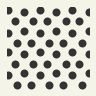

In [124]:
def plot_config(pos, figsize=(1.5,1.5), color='#333333'):
    N, D = pos.shape    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pos[:,0], pos[:,1], color=color, marker='o', markersize=8, markeredgewidth=0.0, linestyle='None')
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    ax.axis('off')
    # want about 64 points
    #q = max(0.05, min(0.5, 64 / N))
    #xlim = np.quantile(pos[:,0], [0.5 - q, 0.5 + q])
    #ylim = np.quantile(pos[:,1], [0.5 - q, 0.5 + q])    
    xlim = (-3,3)
    ylim = (-3,3)
    ax.set_aspect('equal') 
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.tight_layout()
    return skunk.pltsvg(fig=fig)
skunk.display(plot_config(trajs['pg-w0-n16'][0]))

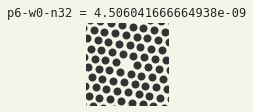

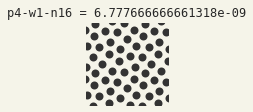

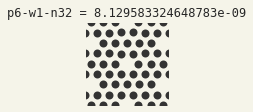

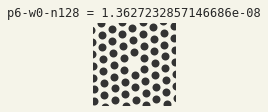

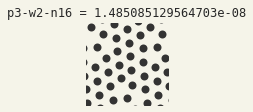

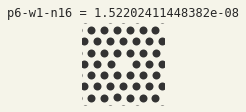

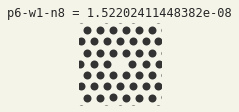

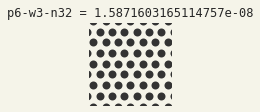

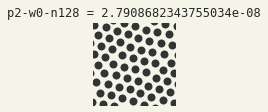

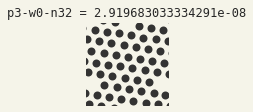

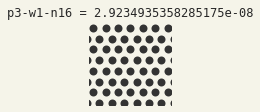

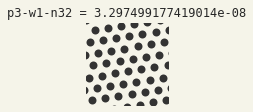

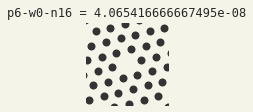

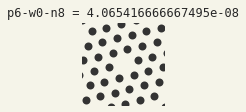

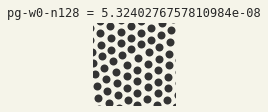

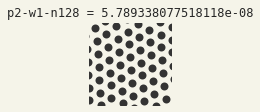

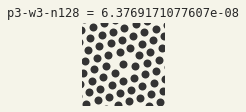

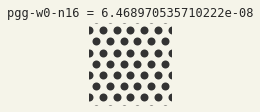

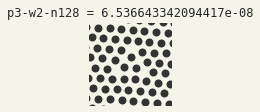

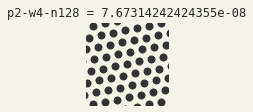

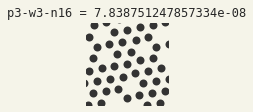

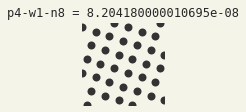

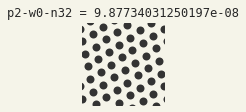

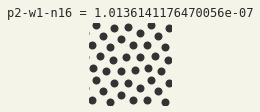

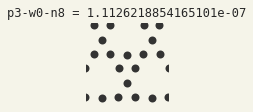

In [125]:
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD'])[:25]
for r,t in zip(top.RMSD.values, top.Traj.values):
    plot_config(trajs[t][0])
    plt.title(f'{t} = {r}')

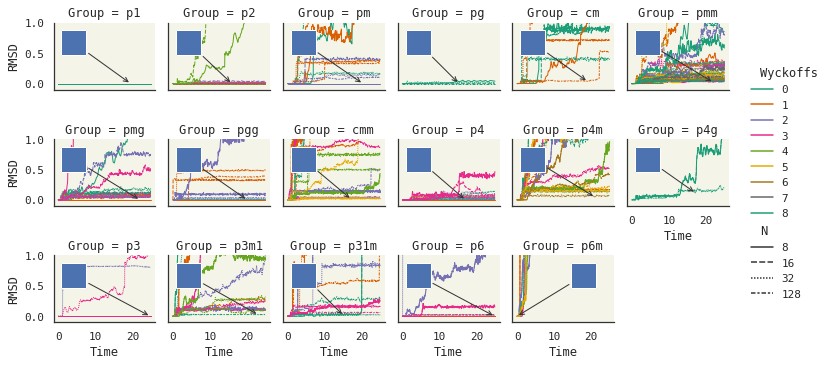

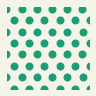

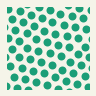

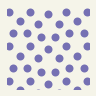

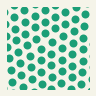

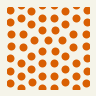

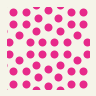

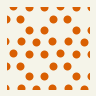

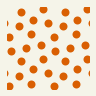

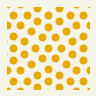

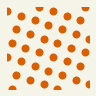

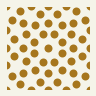

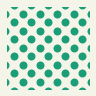

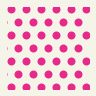

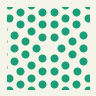

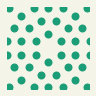

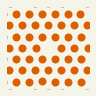

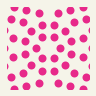

In [142]:
replaces = []
def annotate_config(rmsd, traj, time, wyckoffs, color):
    late_rmsd = rmsd.where(time > 15)
    idx = late_rmsd.argmin()
    label = traj.iloc[idx]
    w = wyckoffs.iloc[idx]
    x = time.iloc[idx]
    y = rmsd.iloc[idx]
    if y > 1:
        x = 0
        y = 0
    replaces.append((label, f'C{w}'))
    ax = plt.gca()
    box = skunk.Box(25, 25, label)    
    ab = mpl.offsetbox.AnnotationBbox(box, (x, y),
                        pad=0,
                        bboxprops=dict(edgecolor='#333', linewidth=1),
                        xybox=(0.7 if x == 0 else 0.2, 0.7),
                        xycoords='data',
                        boxcoords='axes fraction',
                        arrowprops=dict(arrowstyle="->",color='#333'))

    ax.add_artist(ab)

g = sns.relplot(data=cdf.query('rho > 0.5'), x='Time', y='RMSD', 
        kind='line', hue='Wyckoffs', col='Group', col_wrap=6,
        aspect=1, linewidth=1, style='N', height=1.75, palette='Dark2',
               hue_order=[str(i) for i in range(9)])
plt.ylim(-0.1,1)
#sns.move_legend(g, "lower right", bbox_to_anchor=(0.9,0.1), ncol=3)
g.map(annotate_config, 'RMSD', 'Traj', 'Time', 'Wyckoffs').set_axis_labels("Time", "RMSD")

main_svg = skunk.pltsvg()
svg = skunk.insert({l: plot_config(trajs[l][0], color=c) for l,c in replaces}, svg=main_svg)
skunk.display(svg)
with open('atlas.svg', 'w') as f:
    f.write(svg)

In [139]:
cdf.query('rho > 0.5').Traj.unique().shape

(258,)

## Movie

In [21]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markersize=7, markeredgewidth=1.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    #xlim = np.quantile(traj[:,:,0], [0.3, 0.8])
    #ylim = np.quantile(traj[:,:,1], [0.3, 0.8])
    xlim = (-12,12)
    ylim = (-12,12)
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

Moviepy - Building video p3.mp4.
Moviepy - Writing video p3.mp4



Moviepy - Done !
Moviepy - video ready p3.mp4


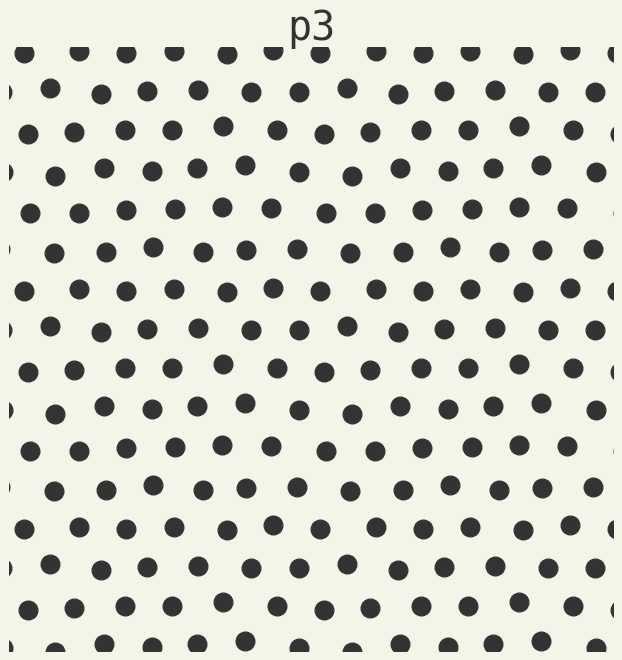

In [92]:
c = plot_traj(traj, title='p3')
write_video([c], f'p3.mp4')

t:   2%|███▊                                                                                                                                                                                                                                | 69/4125 [13:45<01:58, 34.34it/s, now=None]

Moviepy - Building video top.mp4.
Moviepy - Writing video top.mp4




t:   5%|███████████▏                                                                                                                                                                                                                       | 203/4125 [00:07<03:11, 20.47it/s, now=None]


t:   9%|████████████████████                                                                                                                                                                                                               | 364/4125 [00:15<03:08, 19.97it/s, now=None]


t:  13%|████████████████████████████▊                                                                                                                                                                                                      | 523/4125 [00:23<03:10, 18.94it/s, now=None]


t:  17%|█████████████████████████████████████▋                                                                                                                                                                                             | 685/4125 [00:31<03:13, 17.82it/s, now=None]


t:  21%|██████████████████████████████████████████████▌                                                                                                                                                                                    | 847/4125 [00:40<03:22, 16.19it/s, now=None]


t:  24%|███████████████████████████████████████████████████████▎                                                                                                                                                                          | 1009/4125 [00:48<03:32, 14.66it/s, now=None]


t:  28%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 1171/4125 [00:56<03:57, 12.42it/s, now=None]


t:  32%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 1334/4125 [01:04<03:42, 12.55it/s, now=None]


t:  36%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1497/4125 [01:12<03:26, 12.70it/s, now=None]


t:  40%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1660/4125 [01:21<03:04, 13.33it/s, now=None]


t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1819/4125 [01:29<02:21, 16.25it/s, now=None]


t:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1973/4125 [01:37<01:42, 21.09it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2134/4125 [01:45<01:32, 21.50it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2276/4125 [01:53<01:36, 19.21it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2401/4125 [02:00<01:28, 19.46it/s, now=None]


t:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2548/4125 [02:08<01:15, 20.78it/s, now=None]


t:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2708/4125 [02:16<01:07, 21.03it/s, now=None]


t:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2868/4125 [02:25<00:59, 20.98it/s, now=None]


t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3028/4125 [02:33<00:51, 21.18it/s, now=None]


t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3188/4125 [02:41<00:44, 20.84it/s, now=None]


t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3343/4125 [02:49<00:40, 19.51it/s, now=None]


t:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3499/4125 [02:57<00:31, 19.92it/s, now=None]


t:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3661/4125 [03:06<00:23, 19.54it/s, now=None]


t:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3821/4125 [03:14<00:18, 16.65it/s, now=None]


t:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3982/4125 [03:22<00:09, 15.85it/s, now=None]


t:   2%|███▊                                                                                                                                                                                                                                | 69/4125 [17:15<01:58, 34.34it/s, now=None]

Moviepy - Done !
Moviepy - video ready top.mp4


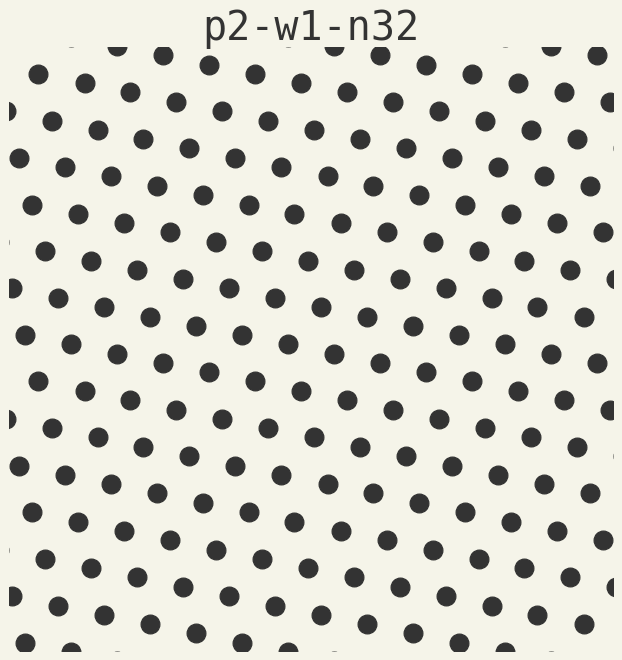

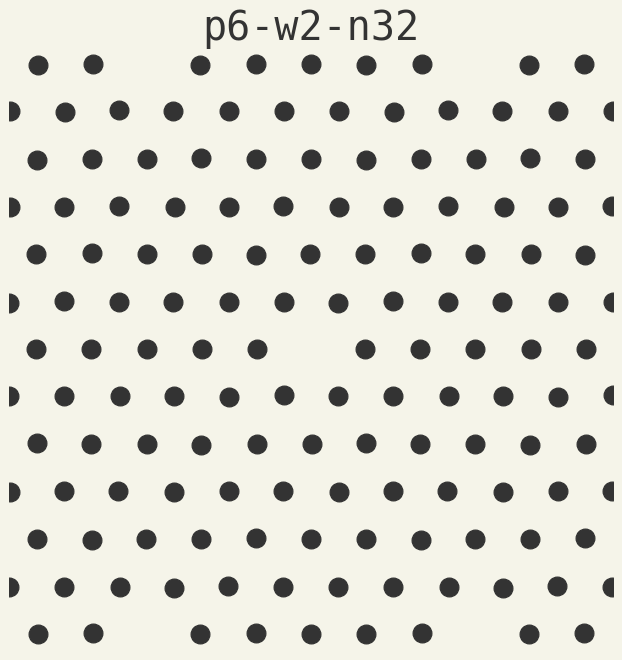

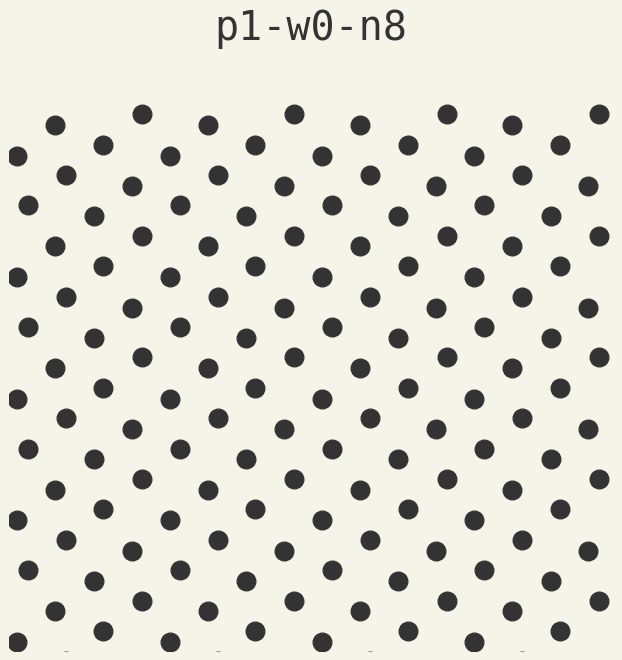

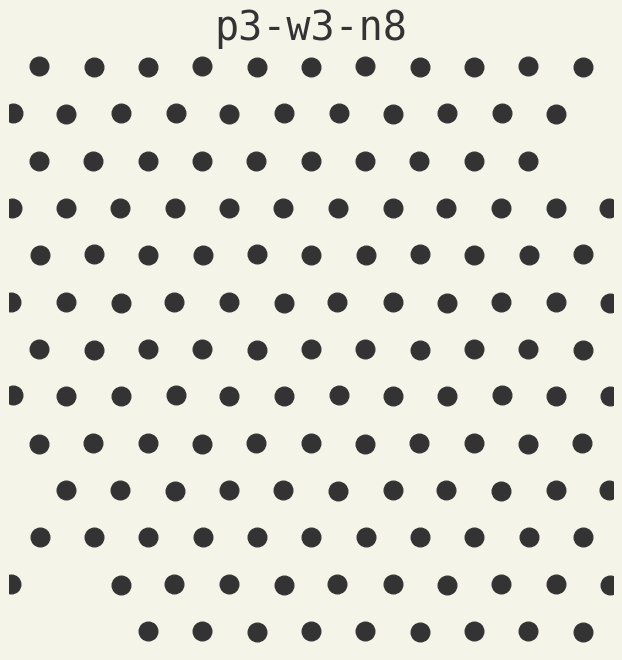

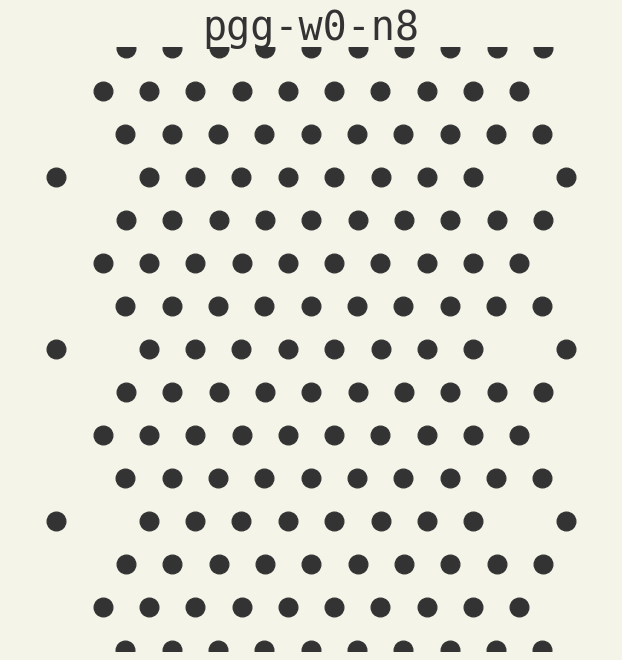

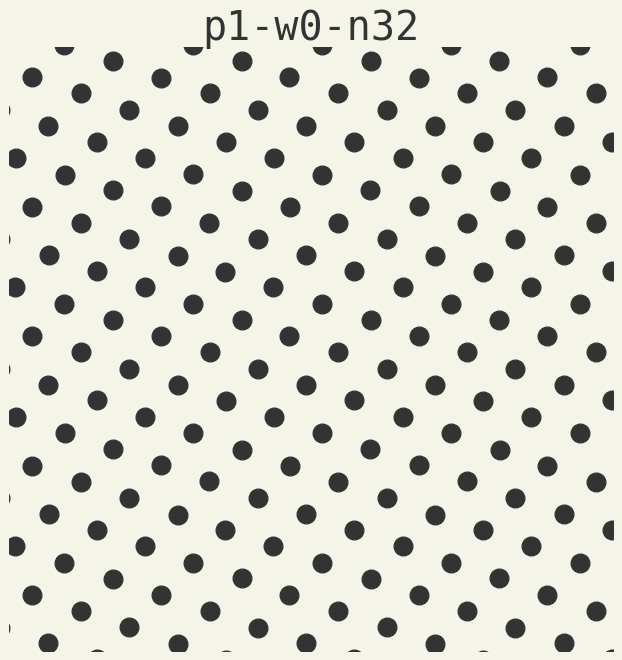

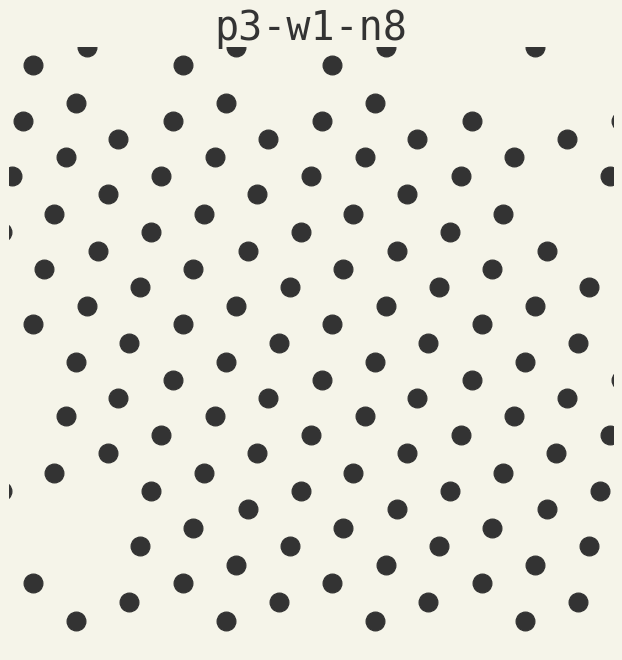

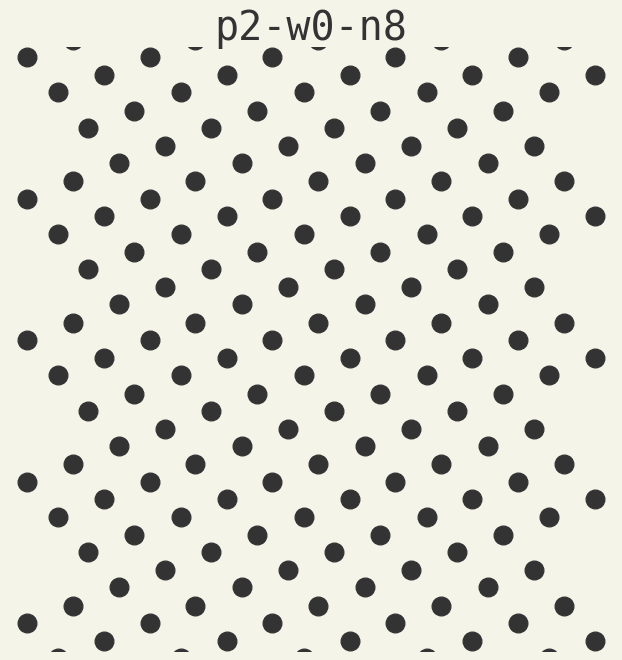

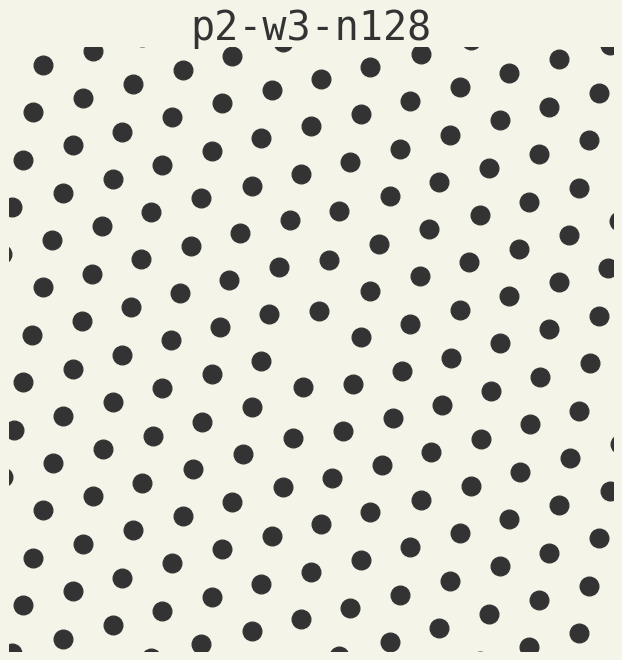

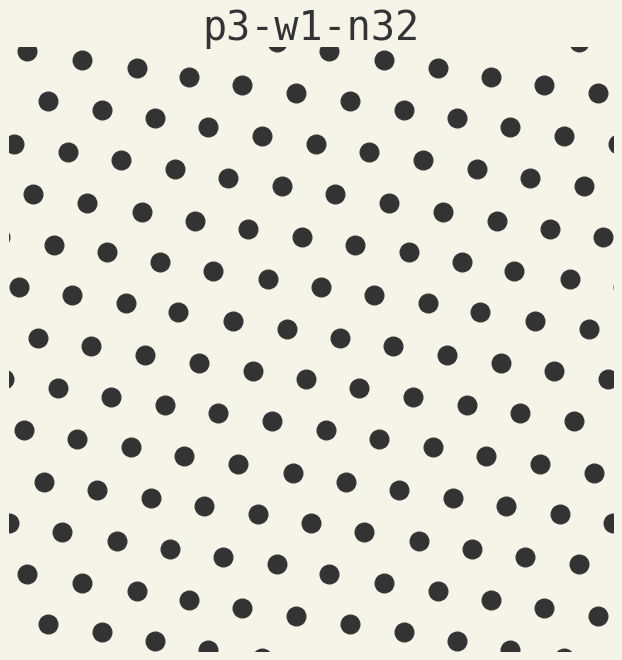

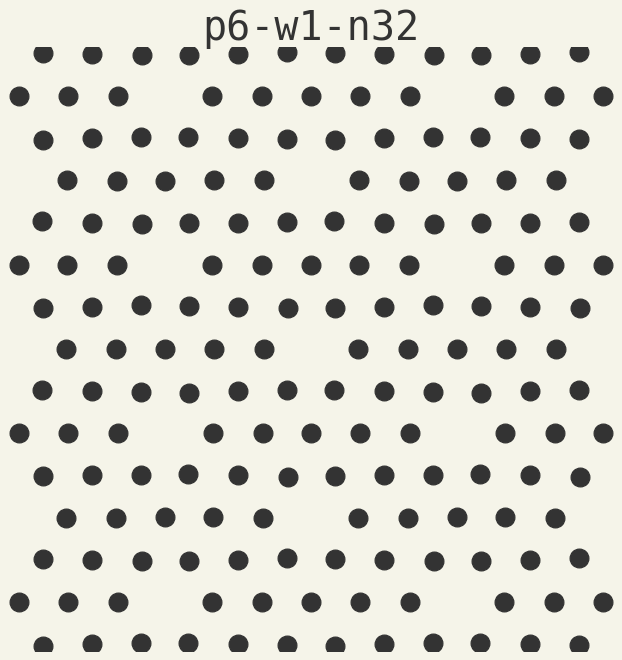

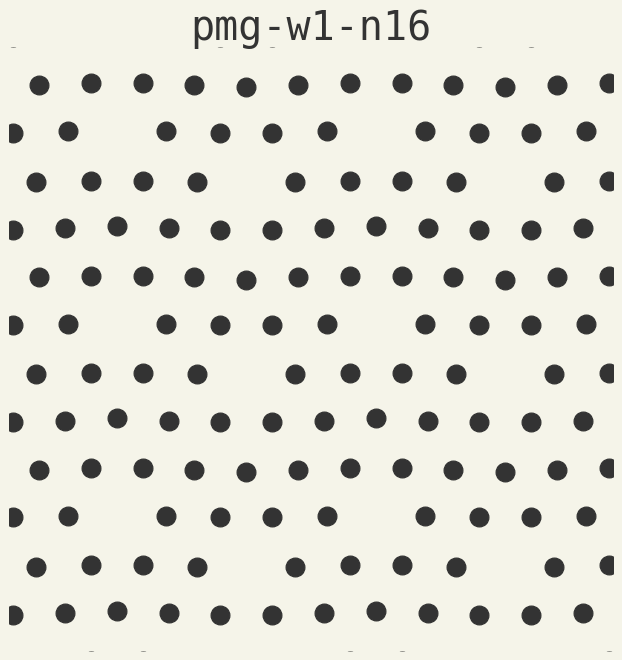

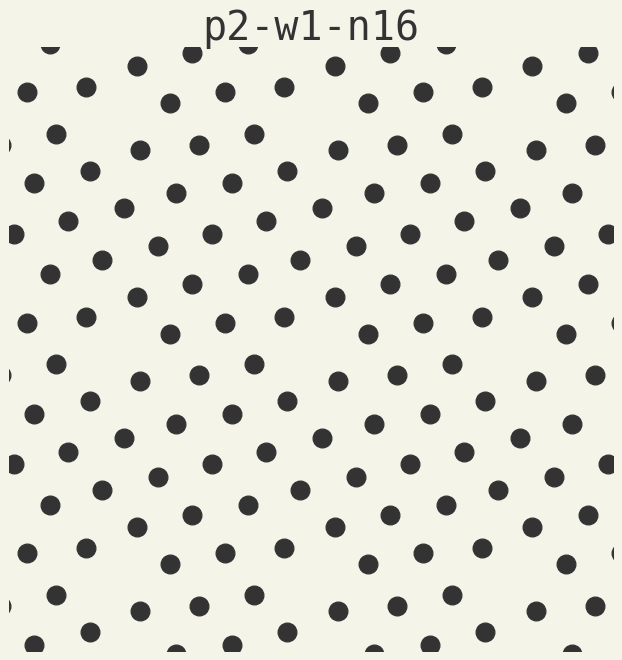

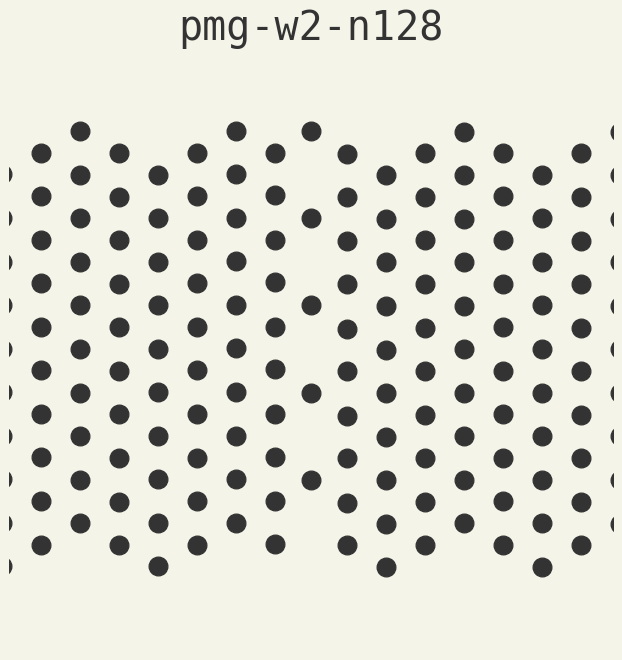

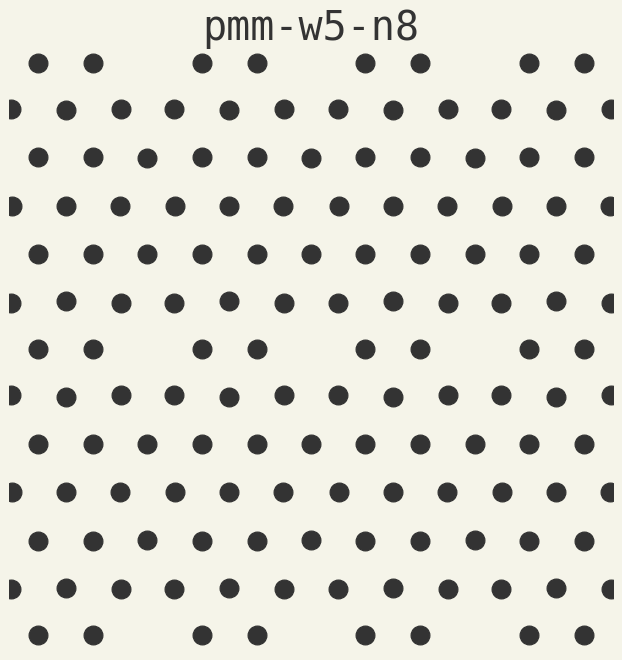

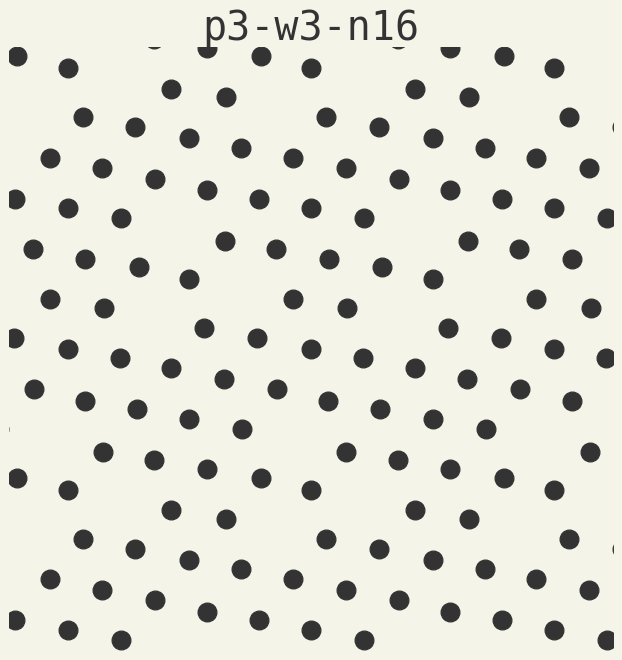

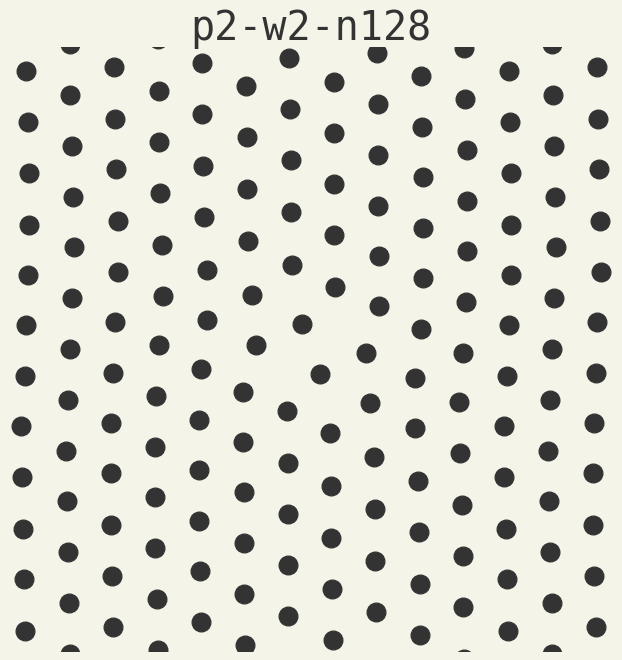

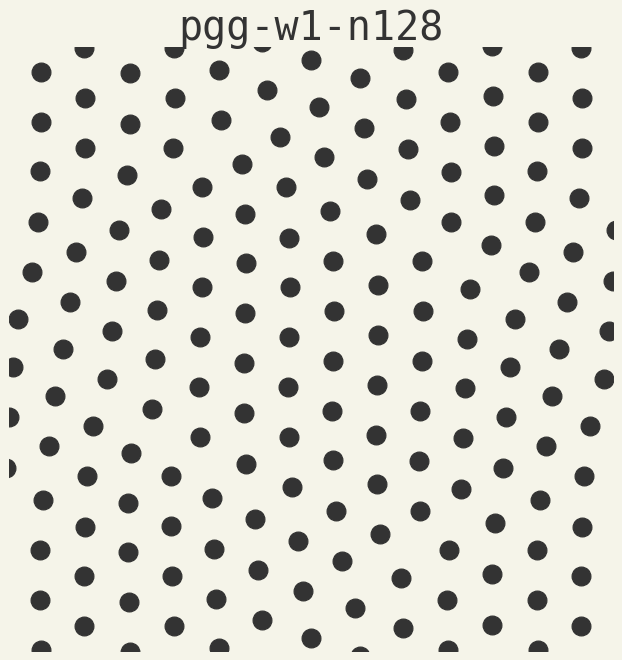

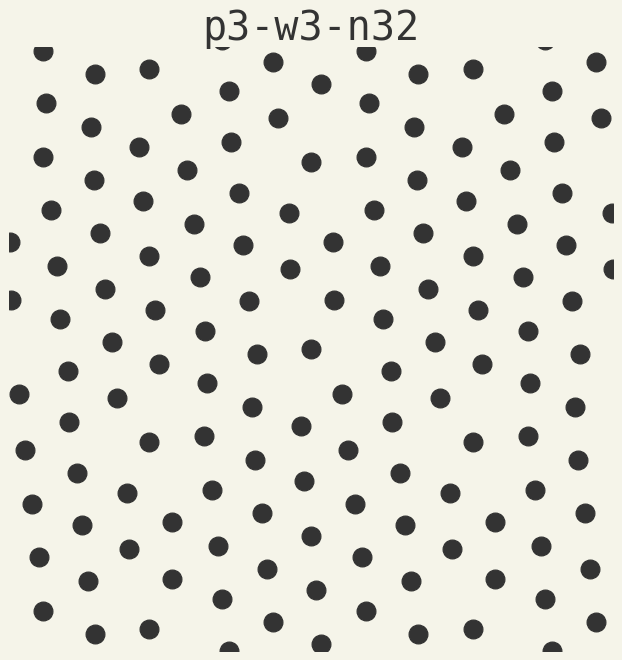

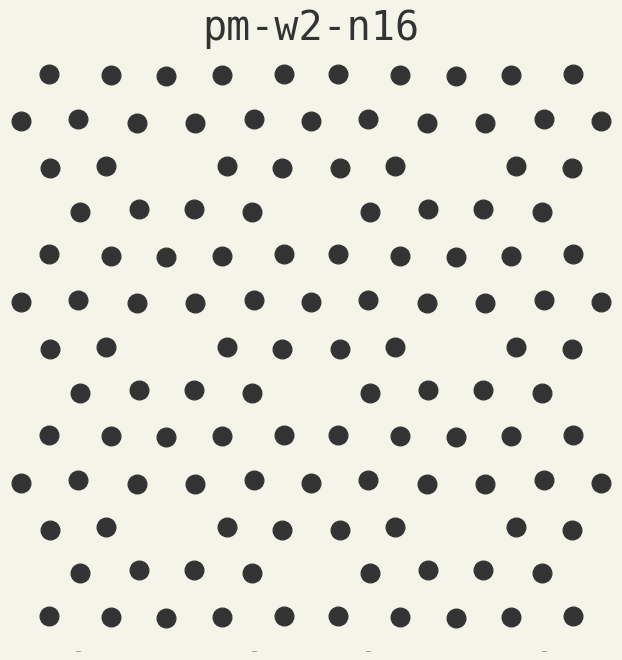

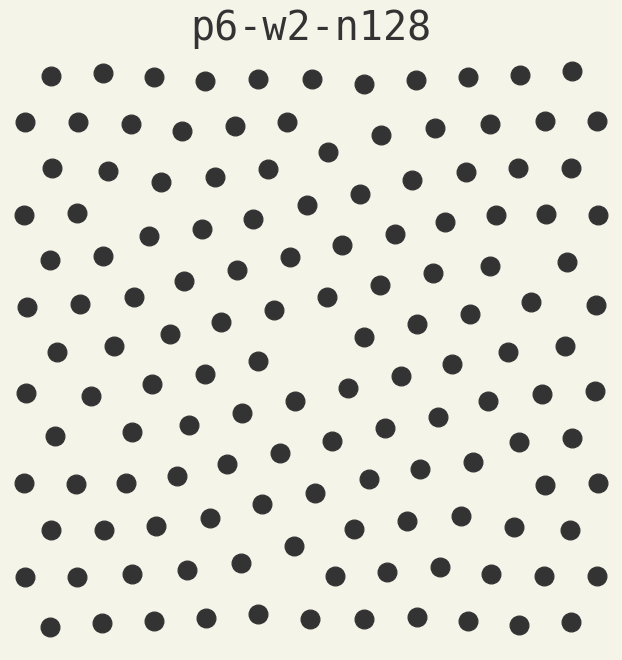

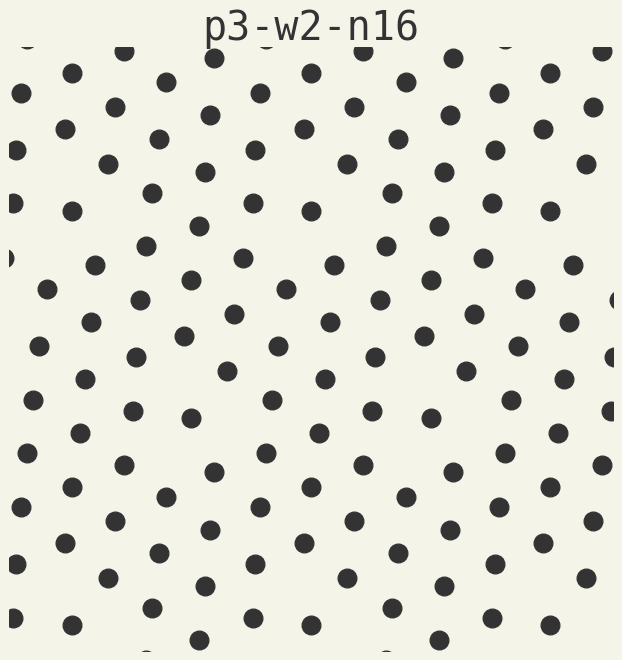

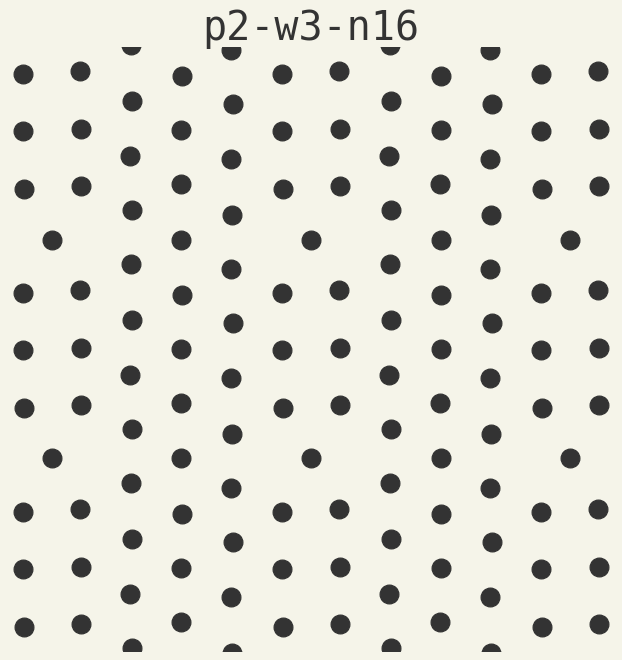

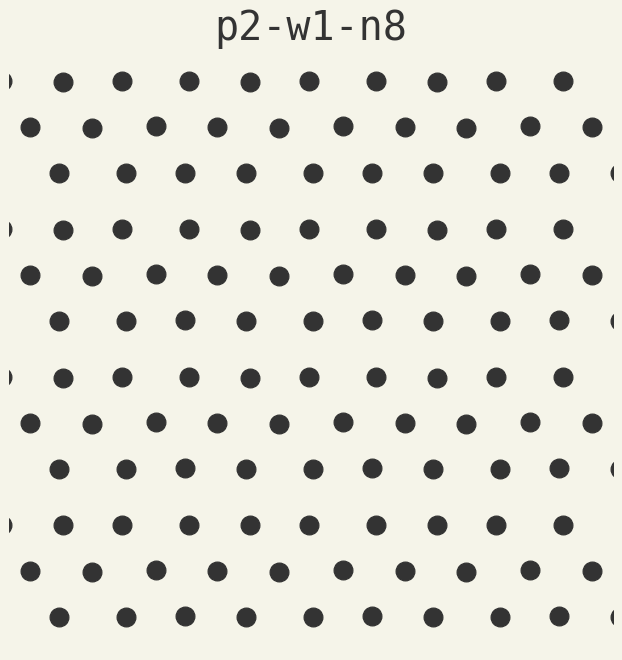

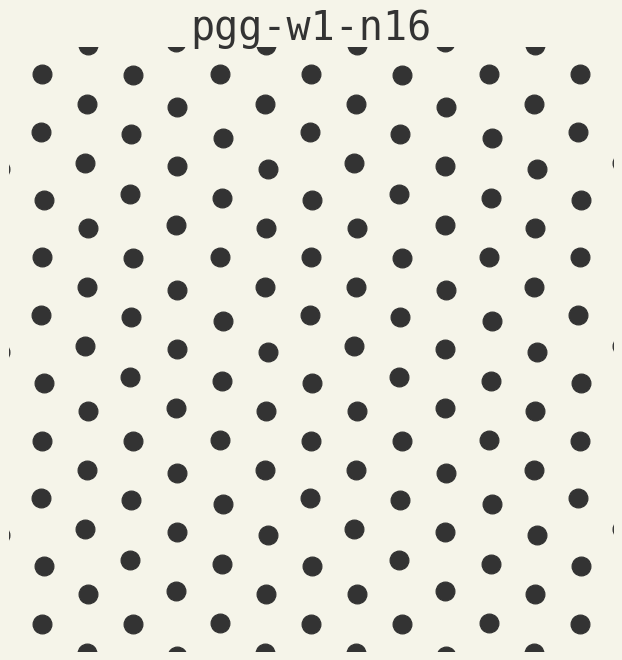

In [34]:
k = 25
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[k:2*k]

clips = []
for t in top:
    c = plot_traj(trajs[t][:60 * 3], title=t)
    clips.append(c)
write_video(clips, 'top.mp4')

Moviepy - Building video sample.mp4.
Moviepy - Writing video sample.mp4



Moviepy - Done !
Moviepy - video ready sample.mp4


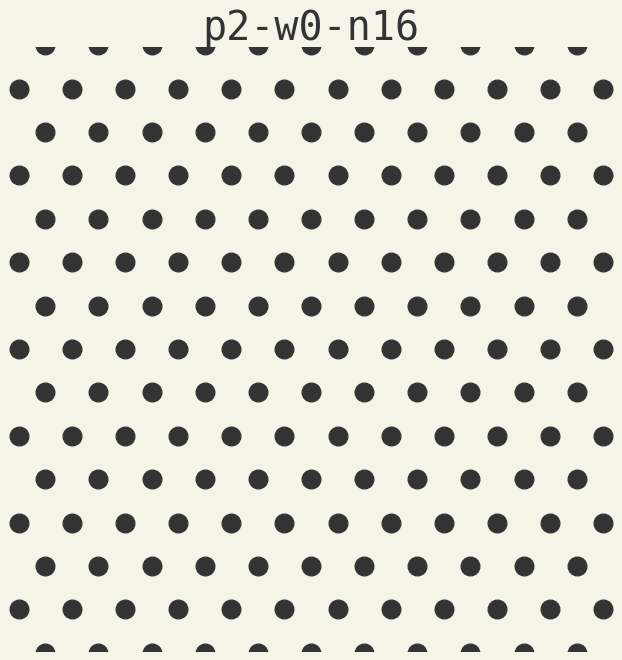

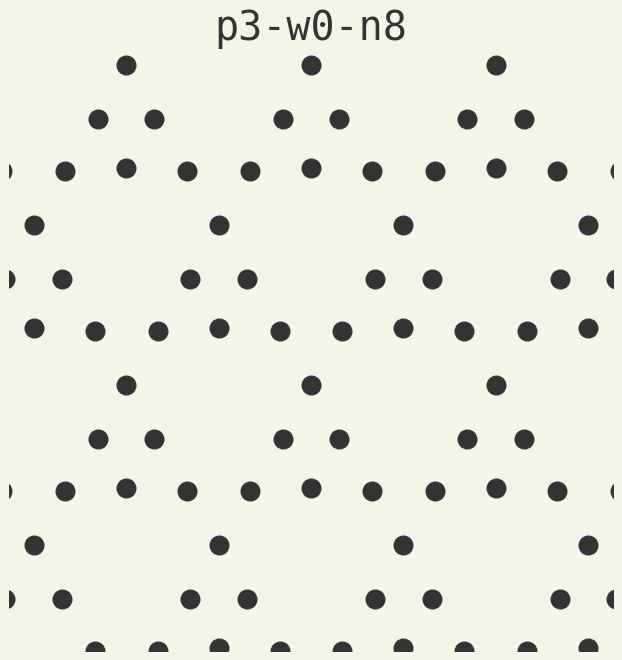

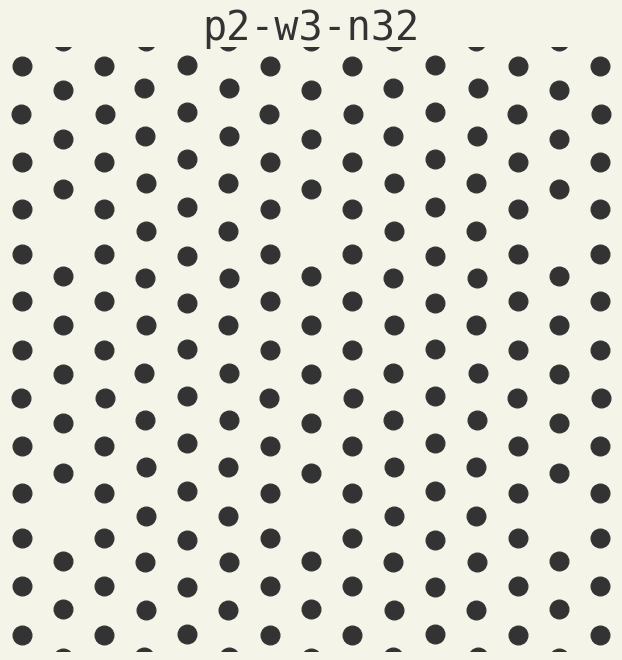

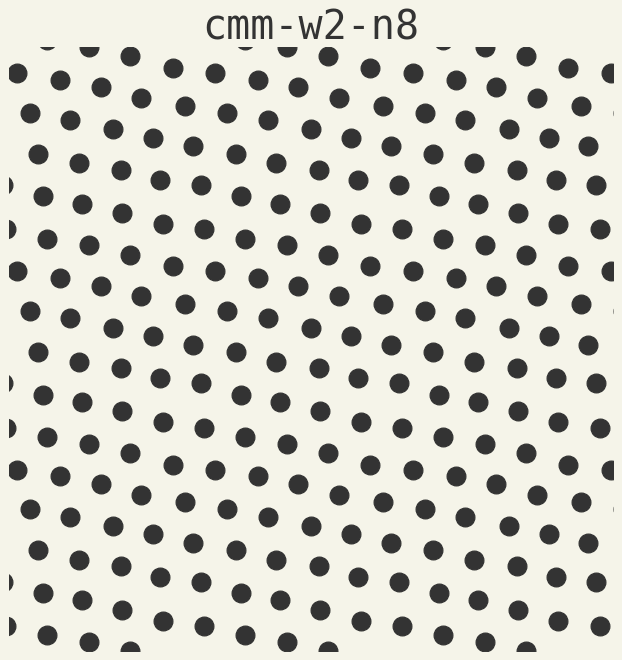

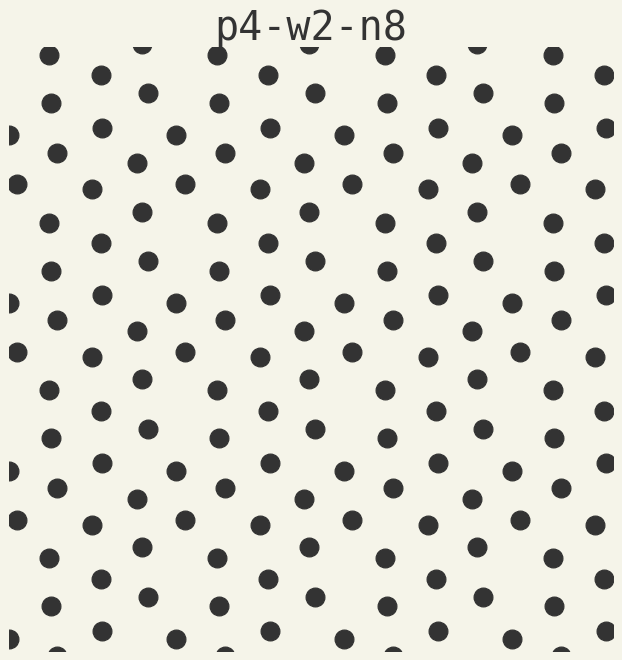

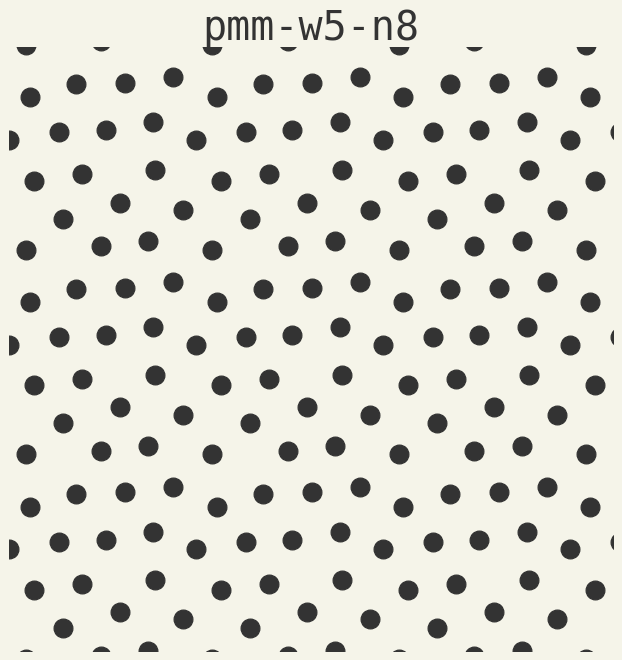

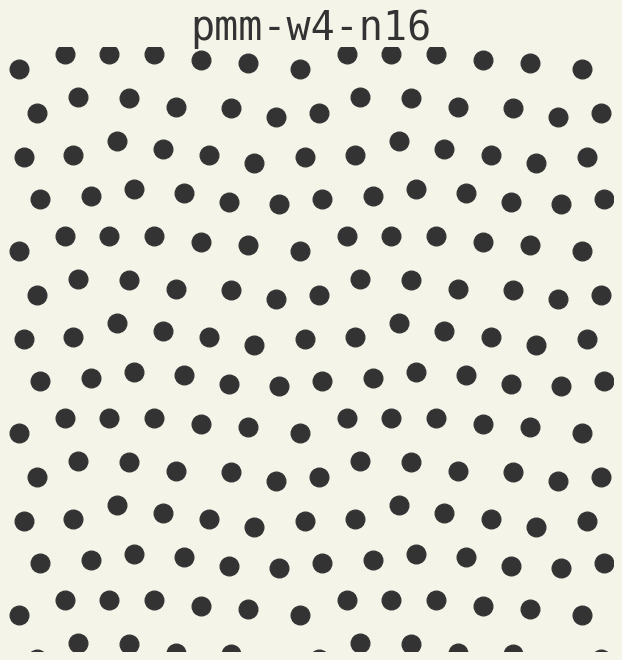

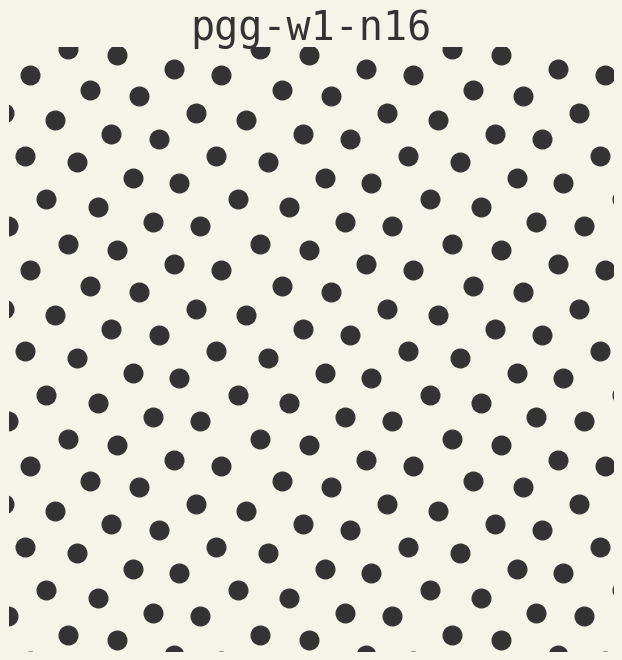

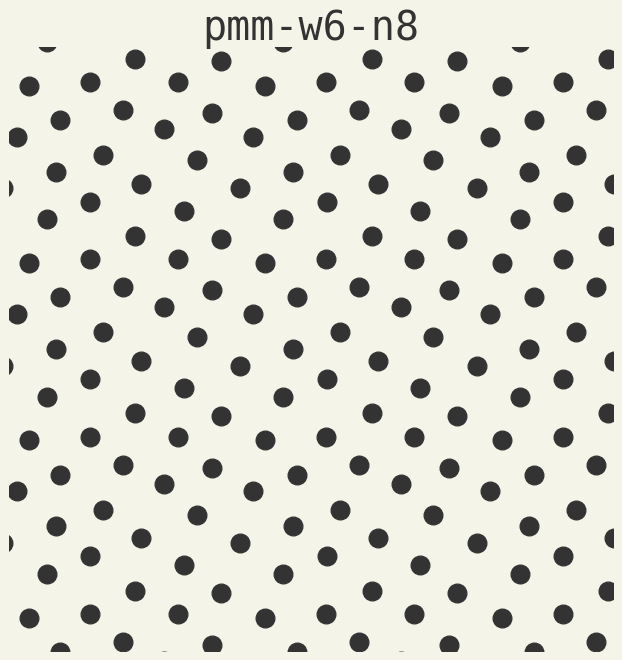

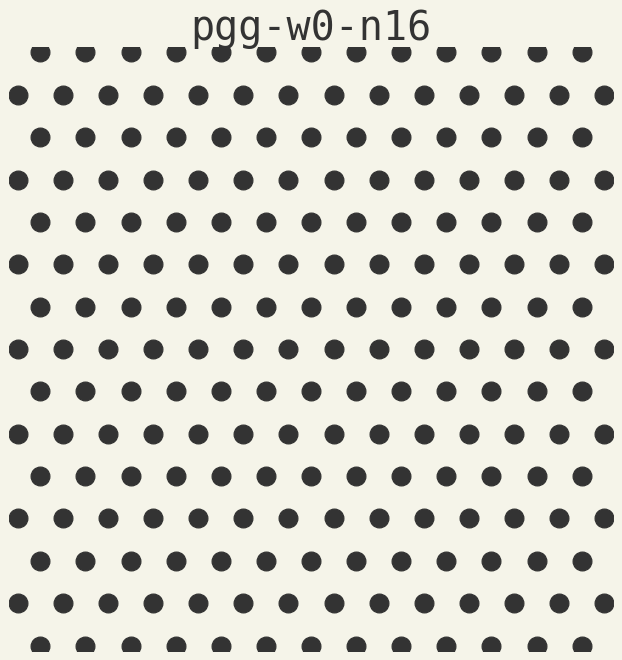

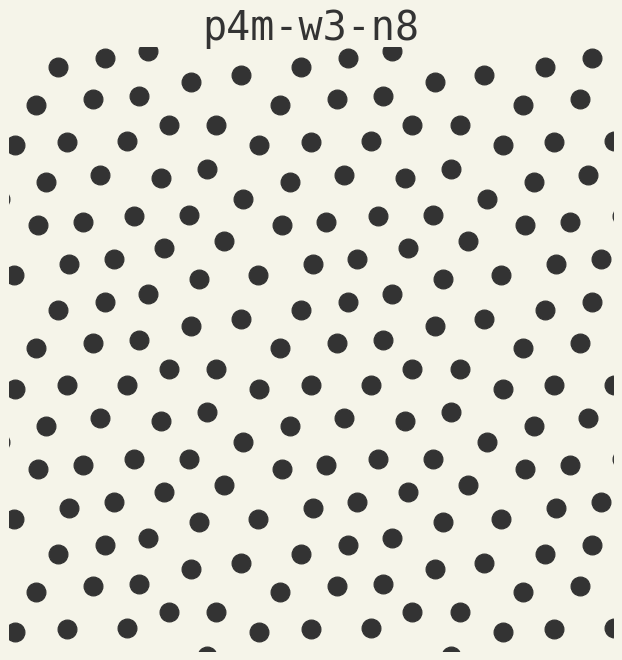

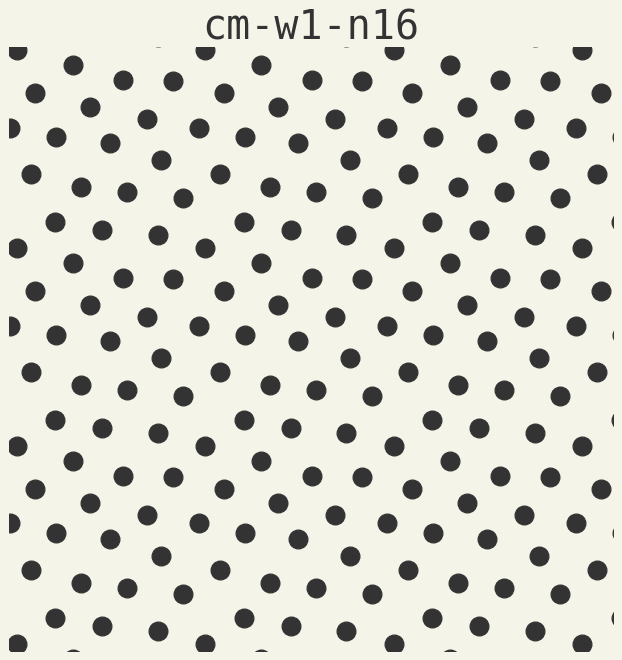

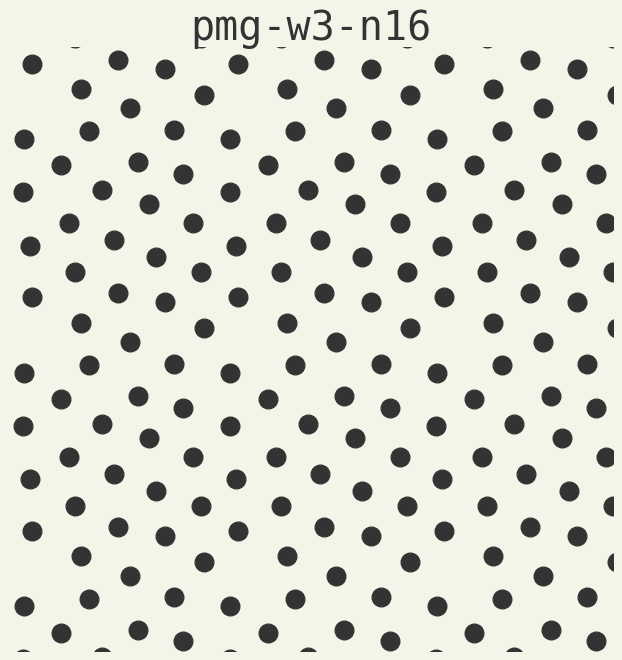

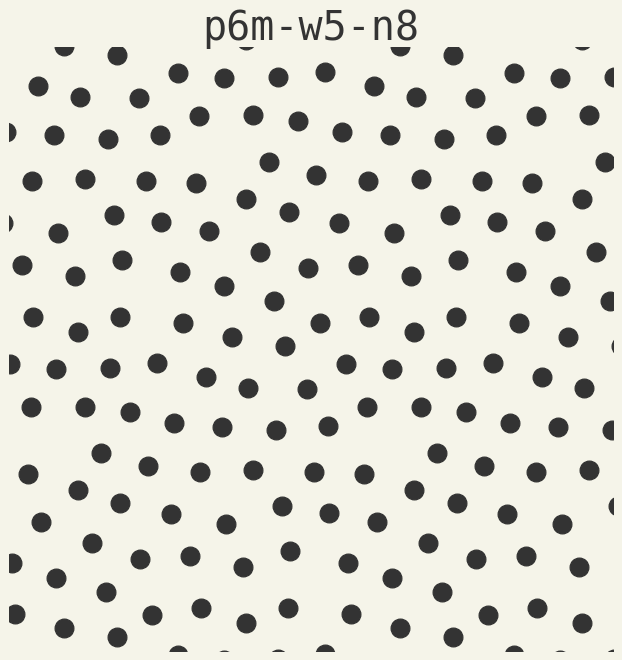

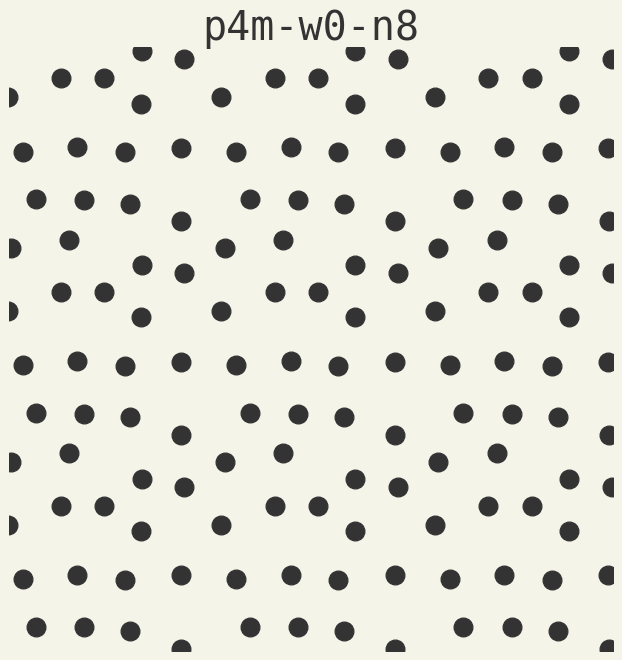

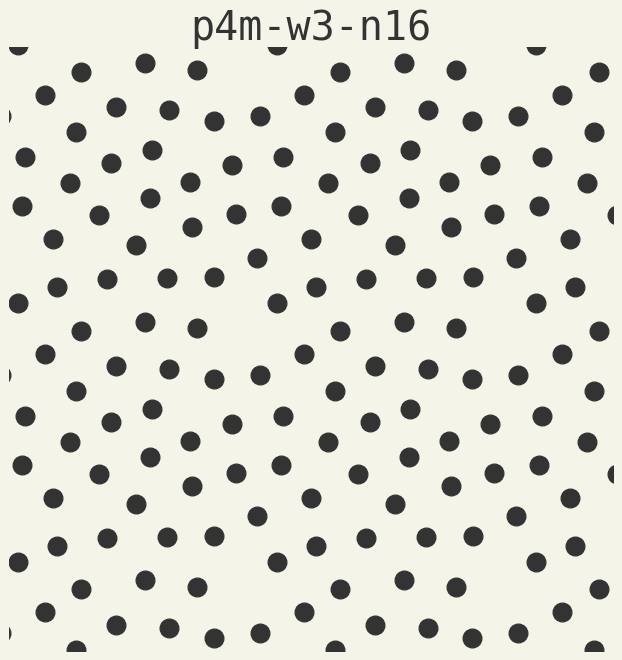

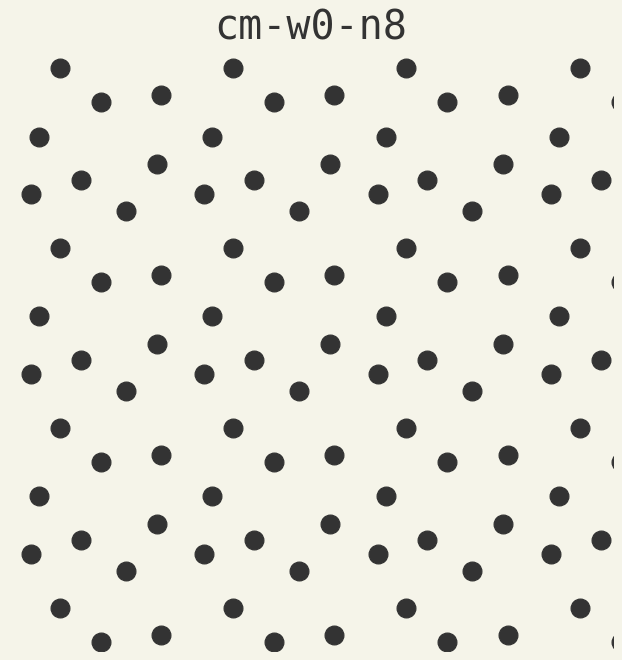

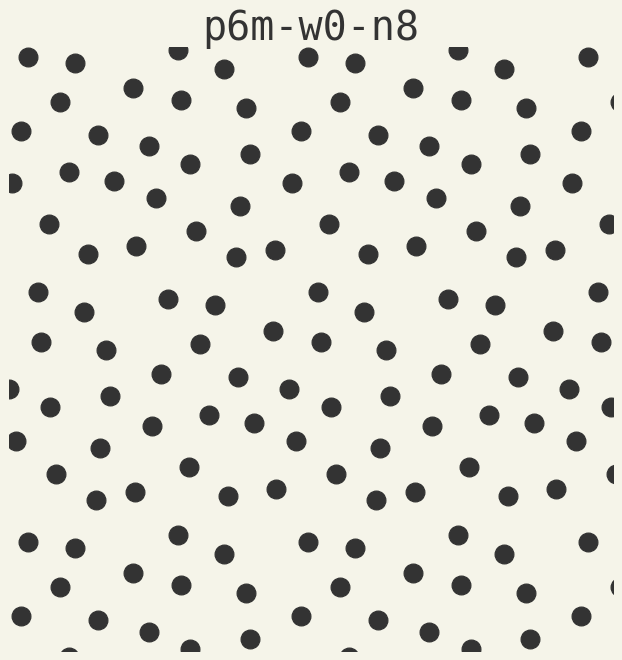

In [93]:
k = 25
bottom = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[10::8]

clips = []
for t in bottom:
    # find when break-up happens
    r = cdf[cdf.Traj == t].RMSD.values
    mint = 60
    delta = r[mint+1:] - r[mint:-1]
    i = np.argmax(delta) + 180
    c = plot_traj(trajs[t][:i+mint], title=t)
    clips.append(c)
write_video(clips, 'sample.mp4')

## Protocol Movie

In [27]:
traj = crystal(32, 4, positions=True)

Simulating 16 particles: 4-16


t:   2%|███▊                                                                                                                                                                                                                                | 69/4135 [00:16<01:51, 36.55it/s, now=None]

                                                                                                                                                                                                                                                                                        
t:   3%|██████▌                                                                                                                                                                                                                            | 120/4135 [01:05<01:54, 35.07it/s, now=None]
                                                                                                                                                                                                                                                                                        
t:   2%|███▊                                                                                                                                                 

Moviepy - Building video protocol.mp4.
Moviepy - Writing video protocol.mp4





t:   0%|                                                                                                                                                                                                                                             | 0/4585 [00:00<?, ?it/s, now=None]

t:   0%|▏                                                                                                                                                                                                                                    | 4/4585 [00:00<01:57, 39.10it/s, now=None]

t:   0%|▍                                                                                                                                                                                                                                    | 8/4585 [00:00<01:59, 38.22it/s, now=None]

t:   0%|▌                                                                                                                                               

t:   2%|█████▌                                                                                                                                                                                                                             | 112/4585 [00:03<02:04, 35.85it/s, now=None]

t:   3%|█████▋                                                                                                                                                                                                                             | 116/4585 [00:03<02:06, 35.41it/s, now=None]

t:   3%|█████▉                                                                                                                                                                                                                             | 120/4585 [00:03<02:06, 35.19it/s, now=None]

t:   3%|██████▏                                                                                                                                           

t:   5%|███████████                                                                                                                                                                                                                        | 224/4585 [00:06<02:04, 35.00it/s, now=None]

t:   5%|███████████▎                                                                                                                                                                                                                       | 228/4585 [00:06<02:04, 35.04it/s, now=None]

t:   5%|███████████▍                                                                                                                                                                                                                       | 232/4585 [00:06<02:02, 35.54it/s, now=None]

t:   5%|███████████▋                                                                                                                                      

t:   7%|████████████████▋                                                                                                                                                                                                                  | 336/4585 [00:09<02:03, 34.42it/s, now=None]

t:   7%|████████████████▊                                                                                                                                                                                                                  | 340/4585 [00:09<02:03, 34.38it/s, now=None]

t:   8%|█████████████████                                                                                                                                                                                                                  | 344/4585 [00:09<02:01, 34.87it/s, now=None]

t:   8%|█████████████████▏                                                                                                                                

t:  10%|██████████████████████▏                                                                                                                                                                                                            | 448/4585 [00:12<01:57, 35.11it/s, now=None]

t:  10%|██████████████████████▍                                                                                                                                                                                                            | 452/4585 [00:12<01:56, 35.51it/s, now=None]

t:  10%|██████████████████████▌                                                                                                                                                                                                            | 456/4585 [00:13<01:55, 35.64it/s, now=None]

t:  10%|██████████████████████▊                                                                                                                           

t:  12%|███████████████████████████▋                                                                                                                                                                                                       | 560/4585 [00:16<01:56, 34.68it/s, now=None]

t:  12%|███████████████████████████▉                                                                                                                                                                                                       | 564/4585 [00:16<01:54, 35.17it/s, now=None]

t:  12%|████████████████████████████                                                                                                                                                                                                       | 568/4585 [00:16<01:53, 35.25it/s, now=None]

t:  12%|████████████████████████████▎                                                                                                                     

t:  15%|█████████████████████████████████▎                                                                                                                                                                                                 | 672/4585 [00:19<01:58, 33.08it/s, now=None]

t:  15%|█████████████████████████████████▍                                                                                                                                                                                                 | 676/4585 [00:19<01:57, 33.37it/s, now=None]

t:  15%|█████████████████████████████████▋                                                                                                                                                                                                 | 680/4585 [00:19<01:56, 33.48it/s, now=None]

t:  15%|█████████████████████████████████▊                                                                                                                

t:  17%|██████████████████████████████████████▊                                                                                                                                                                                            | 784/4585 [00:22<01:49, 34.86it/s, now=None]

t:  17%|███████████████████████████████████████                                                                                                                                                                                            | 788/4585 [00:22<01:48, 35.11it/s, now=None]

t:  17%|███████████████████████████████████████▏                                                                                                                                                                                           | 792/4585 [00:22<01:49, 34.74it/s, now=None]

t:  17%|███████████████████████████████████████▍                                                                                                          

t:  20%|████████████████████████████████████████████▎                                                                                                                                                                                      | 896/4585 [00:25<01:53, 32.58it/s, now=None]

t:  20%|████████████████████████████████████████████▌                                                                                                                                                                                      | 900/4585 [00:26<01:52, 32.83it/s, now=None]

t:  20%|████████████████████████████████████████████▊                                                                                                                                                                                      | 904/4585 [00:26<01:51, 33.00it/s, now=None]

t:  20%|████████████████████████████████████████████▉                                                                                                     

t:  22%|█████████████████████████████████████████████████▋                                                                                                                                                                                | 1008/4585 [00:29<01:51, 32.16it/s, now=None]

t:  22%|█████████████████████████████████████████████████▉                                                                                                                                                                                | 1012/4585 [00:29<01:51, 32.11it/s, now=None]

t:  22%|██████████████████████████████████████████████████                                                                                                                                                                                | 1016/4585 [00:29<01:51, 32.02it/s, now=None]

t:  22%|██████████████████████████████████████████████████▎                                                                                               

t:  24%|███████████████████████████████████████████████████████▏                                                                                                                                                                          | 1120/4585 [00:32<01:42, 33.89it/s, now=None]

t:  25%|███████████████████████████████████████████████████████▍                                                                                                                                                                          | 1124/4585 [00:32<01:42, 33.86it/s, now=None]

t:  25%|███████████████████████████████████████████████████████▌                                                                                                                                                                          | 1128/4585 [00:32<01:42, 33.76it/s, now=None]

t:  25%|███████████████████████████████████████████████████████▊                                                                                          

t:  27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 1232/4585 [00:36<01:37, 34.46it/s, now=None]

t:  27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 1236/4585 [00:36<01:37, 34.30it/s, now=None]

t:  27%|█████████████████████████████████████████████████████████████                                                                                                                                                                     | 1240/4585 [00:36<01:38, 34.03it/s, now=None]

t:  27%|█████████████████████████████████████████████████████████████▎                                                                                    

t:  29%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 1344/4585 [00:39<01:41, 32.07it/s, now=None]

t:  29%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 1348/4585 [00:39<01:39, 32.47it/s, now=None]

t:  29%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 1352/4585 [00:39<01:41, 32.01it/s, now=None]

t:  30%|██████████████████████████████████████████████████████████████████▊                                                                               

t:  32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 1456/4585 [00:42<01:31, 34.32it/s, now=None]

t:  32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 1460/4585 [00:42<01:30, 34.50it/s, now=None]

t:  32%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 1464/4585 [00:43<01:29, 34.87it/s, now=None]

t:  32%|████████████████████████████████████████████████████████████████████████▎                                                                         

t:  34%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 1564/4585 [00:46<01:34, 31.99it/s, now=None]

t:  34%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 1568/4585 [00:46<01:32, 32.68it/s, now=None]

t:  34%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 1572/4585 [00:46<01:30, 33.34it/s, now=None]

t:  34%|█████████████████████████████████████████████████████████████████████████████▋                                                                    

t:  37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 1676/4585 [00:49<01:26, 33.59it/s, now=None]

t:  37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 1680/4585 [00:49<01:26, 33.63it/s, now=None]

t:  37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 1684/4585 [00:49<01:26, 33.54it/s, now=None]

t:  37%|███████████████████████████████████████████████████████████████████████████████████▏                                                              

t:  39%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 1788/4585 [00:52<01:23, 33.51it/s, now=None]

t:  39%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 1792/4585 [00:53<01:22, 33.72it/s, now=None]

t:  39%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1796/4585 [00:53<01:22, 33.83it/s, now=None]

t:  39%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         

t:  41%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1900/4585 [00:56<01:26, 31.14it/s, now=None]

t:  42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1904/4585 [00:56<01:23, 31.92it/s, now=None]

t:  42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 1908/4585 [00:56<01:21, 32.79it/s, now=None]

t:  42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   

t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 2012/4585 [00:59<01:17, 33.24it/s, now=None]

t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 2016/4585 [00:59<01:17, 33.20it/s, now=None]

t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 2020/4585 [01:00<01:16, 33.54it/s, now=None]

t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              

t:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 2124/4585 [01:03<01:14, 32.83it/s, now=None]

t:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 2128/4585 [01:03<01:15, 32.74it/s, now=None]

t:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 2132/4585 [01:03<01:14, 32.81it/s, now=None]

t:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2236/4585 [01:06<01:08, 34.19it/s, now=None]

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 2240/4585 [01:06<01:09, 33.97it/s, now=None]

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 2244/4585 [01:06<01:09, 33.89it/s, now=None]

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   

t:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 2348/4585 [01:09<01:04, 34.70it/s, now=None]

t:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 2352/4585 [01:10<01:04, 34.51it/s, now=None]

t:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 2356/4585 [01:10<01:05, 34.17it/s, now=None]

t:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 2460/4585 [01:13<01:03, 33.65it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 2464/4585 [01:13<01:03, 33.28it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2468/4585 [01:13<01:03, 33.52it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2572/4585 [01:16<01:02, 31.96it/s, now=None]

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2576/4585 [01:16<01:01, 32.74it/s, now=None]

t:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2580/4585 [01:16<01:00, 33.26it/s, now=None]

t:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  

t:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2684/4585 [01:20<00:57, 32.87it/s, now=None]

t:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2688/4585 [01:20<00:57, 33.22it/s, now=None]

t:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2692/4585 [01:20<00:58, 32.55it/s, now=None]

t:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             

t:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2796/4585 [01:23<00:56, 31.70it/s, now=None]

t:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2800/4585 [01:23<00:56, 31.74it/s, now=None]

t:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2804/4585 [01:23<00:56, 31.70it/s, now=None]

t:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       

t:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2908/4585 [01:26<00:53, 31.24it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2912/4585 [01:27<00:53, 31.28it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2916/4585 [01:27<00:53, 31.46it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  

t:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3020/4585 [01:30<00:49, 31.39it/s, now=None]

t:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 3024/4585 [01:30<00:49, 31.34it/s, now=None]

t:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 3028/4585 [01:30<00:49, 31.67it/s, now=None]

t:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3132/4585 [01:33<00:45, 32.19it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 3136/4585 [01:34<00:44, 32.38it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3140/4585 [01:34<00:43, 32.86it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3244/4585 [01:37<00:41, 31.99it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3248/4585 [01:37<00:41, 32.61it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 3252/4585 [01:37<00:41, 32.51it/s, now=None]

t:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3356/4585 [01:40<00:36, 33.69it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3360/4585 [01:40<00:36, 33.18it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 3364/4585 [01:41<00:36, 33.46it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3468/4585 [01:44<00:36, 30.79it/s, now=None]

t:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3472/4585 [01:44<00:36, 30.54it/s, now=None]

t:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3476/4585 [01:44<00:35, 30.84it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3580/4585 [01:47<00:30, 33.07it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3584/4585 [01:47<00:30, 33.18it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3588/4585 [01:48<00:30, 32.94it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3692/4585 [01:51<00:27, 32.62it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3696/4585 [01:51<00:27, 32.52it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3700/4585 [01:51<00:26, 33.00it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3804/4585 [01:54<00:24, 31.38it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3808/4585 [01:54<00:25, 31.02it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3812/4585 [01:54<00:25, 30.76it/s, now=None]

t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3916/4585 [01:58<00:22, 30.33it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3920/4585 [01:58<00:21, 30.29it/s, now=None]

t:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3924/4585 [01:58<00:21, 31.01it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4028/4585 [02:01<00:16, 32.91it/s, now=None]

t:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4032/4585 [02:01<00:17, 32.42it/s, now=None]

t:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4036/4585 [02:01<00:16, 32.97it/s, now=None]

t:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4140/4585 [02:04<00:13, 32.83it/s, now=None]

t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4144/4585 [02:04<00:13, 33.04it/s, now=None]

t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4148/4585 [02:05<00:13, 33.08it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4252/4585 [02:08<00:10, 32.65it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4256/4585 [02:08<00:10, 32.16it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4260/4585 [02:08<00:10, 32.26it/s, now=None]

t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4354/4585 [02:11<00:07, 29.26it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4357/4585 [02:11<00:07, 29.19it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4361/4585 [02:11<00:07, 29.50it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4464/4585 [02:15<00:03, 31.00it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4468/4585 [02:15<00:03, 30.78it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4472/4585 [02:15<00:03, 30.35it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4576/4585 [02:18<00:00, 34.06it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4580/4585 [02:18<00:00, 34.14it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4584/4585 [02:18<00:00, 34.33it/s, now=None]

                                                                                                                                                          

Moviepy - Done !
Moviepy - video ready protocol.mp4


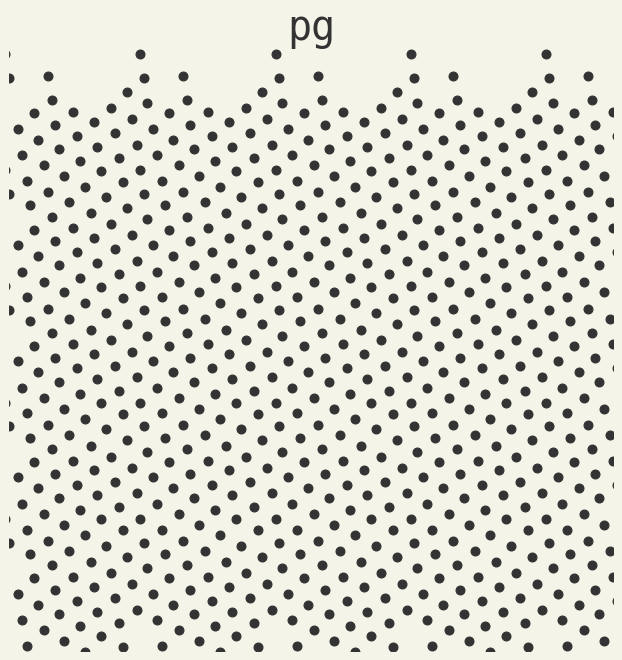

In [28]:
c = plot_traj(traj, title=titles[4 - 1])
write_video([c], 'protocol.mp4')